## < RUN ME >

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import axes3d
import sklearn as sk
import seaborn as sn
import scipy.stats as st

from tqdm import tqdm

%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as skms

## Carga de datos < RUN ME >

In [2]:
#Para cargarlos desde Google Drive
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/FAA_Proyecto')

%cd drive/MyDrive/FAA_Proyecto

Mounted at /content/drive
/content/drive/MyDrive/Practicas_Ciencia_Datos/FAA_Proyecto


In [ ]:
%ls

 0_exploracion_datos.ipynb               pca_3d_est.mp4
 data/                                   pca_3d.mp4
 Enventanado.ipynb                       pca_coefs.png
 FAA_Proyecto.ipynb                      pca_win_data_test.csv
 lda_error_window_hparams_delay0.2.png   pca_win_data_train.csv
 lda_error_window_hparams.png            Pruebas.ipynb
 LDA_sep_train.png                      'Random Forest.ipynb'
 lda_win_data_test.csv                   semi_pca_3d.mp4
 lda_win_data_train.csv                  ts_meta_test.csv
 lda_win_error_free_priors.png           ts_meta_train.csv
 lda_win_free_priors_long.png            ts_test.csv
 lda_win_free_priors.png                 ts_to_win_fig.png
 mpca2D_sep.png                          ts_train.csv
 mpca_win_data_test.csv                  win_data_test_sc.csv
 mpca_win_data_train.csv                 win_data_train_sc.csv
 pca2D_sep.png


### Series temporales completas

In [ ]:
npdata = np.loadtxt("data/HT.dat", dtype=str)

# time series data
ts_data = pd.DataFrame(npdata[1:,:], columns=npdata[0,:])
ts_data = ts_data.astype(float)
ts_data['id'] = ts_data['id'].astype(int)
ts_data.head()

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp.,Humidity
0,0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528
1,0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299
2,0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093
3,0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905
4,0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736


### Información sobre las series temporales (clase, dt, ...)

In [ ]:
npmeta = np.loadtxt("data/HT.metadat", dtype=str)

# time series metadata (estímulo de 0 a 0+dt y clase del estímulo)
ts_meta = pd.DataFrame(npmeta[1:,:], columns=npmeta[0,:])
ts_meta['dt'] = ts_meta['dt'].astype(float)
ts_meta['t0'] = ts_meta['t0'].astype(float)
ts_meta['id'] = ts_meta['id'].astype(int)

ts_meta.head()

,id,date,class,t0,dt
0,0,07-04-15,banana,13.49,1.64
1,1,07-05-15,wine,19.61,0.54
2,2,07-06-15,wine,19.99,0.66
3,3,07-09-15,banana,6.49,0.72
4,4,07-09-15,wine,20.07,0.53


La serie 95 aparece en el archivo de metadatos pero no tiene información en el archivo de series temporales asi que la eliminamos (facilita el parseo en etapas posteriores del procesamiento).

In [ ]:
ts_meta = ts_meta.loc[ts_meta['id']!=95]
ts_meta

,id,date,class,t0,dt
0,0,07-04-15,banana,13.49,1.64
1,1,07-05-15,wine,19.61,0.54
2,2,07-06-15,wine,19.99,0.66
3,3,07-09-15,banana,6.49,0.72
4,4,07-09-15,wine,20.07,0.53
...,...,...,...,...,...
94,94,09-10-15,background,14.94,0.79
96,96,09-14-15,background,13.37,0.94
97,97,09-15-15,background,14.25,0.72
98,98,09-16-15,background,14.41,0.71


## [AEY] - Análisis exploratorio de series temporales

In [ ]:
def missing_value_inspection(df):
    
    for column in df.columns:
        dtype = df[column].dtype
        na_flag = np.any(df[column].isna())
        null_flag = np.any(df[column].isnull())
        values = df[column].unique()
        if not (na_flag or null_flag):
            values = np.sort(values)
        print(f"{column}: {dtype}\n--------------")
        print(f"\tNAs: {na_flag}")
        print(f"\tNULLs: {null_flag}")
        print(f"\tValues:{values}\n")

In [ ]:
missing_value_inspection(ts_data)

id: int64
--------------
	NAs: False
	NULLs: False
	Values:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 96
 97 98 99]

time: float64
--------------
	NAs: False
	NULLs: False
	Values:[-0.999999 -0.999998 -0.999997 ...  3.309317  3.309595  3.309882]

R1: float64
--------------
	NAs: False
	NULLs: False
	Values:[ 5.43146  5.43244  5.43363 ... 13.7329  13.7332  13.7333 ]

R2: float64
--------------
	NAs: False
	NULLs: False
	Values:[ 1.82066  1.82679  1.83402 ... 11.3153  11.3154  11.3155 ]

R3: float64
--------------
	NAs: False
	NULLs: False
	Values:[ 1.6269   1.62809  1.62933 ... 11.3738  11.3739  11.3742 ]

R4: float64
--------------
	NAs: False
	NULLs: False
	Values:[ 2.28292  2.28324  2.28345 ... 12.7545  12.7546  12.7548 ]

R5: float64
-------

Text(0.5, 0, '$\\Delta t$')

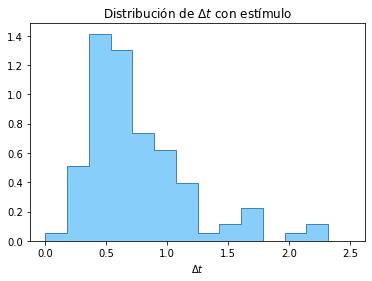

In [ ]:
plt.hist(ts_meta['dt'], bins=np.linspace(0,2.5,15), density=True, histtype='stepfilled',
         color="lightskyblue", edgecolor="steelblue")
plt.title("Distribución de $\Delta t$ con estímulo")
plt.xlabel("$\Delta t$")

La distribución de los $Δt$ en las series puede dar una idea de los tamaños de ventana a utilizar.

### Estandarización de las variables de las series temporales (facilita la visualización)

In [ ]:
ts_sc = StandardScaler()
ts_data_sc = ts_sc.fit_transform(ts_data)
ts_data_sc = pd.DataFrame(ts_data_sc, columns=ts_data.columns)
ts_data_sc['id'] = ts_data['id']
ts_data_sc['time'] = ts_data['time']
ts_data_sc

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp.,Humidity
0,0,-0.999750,0.779562,0.904831,0.853984,0.899352,-0.090317,-0.820466,0.917566,0.855313,-1.169299,0.307931
1,0,-0.999472,0.779101,0.904767,0.853527,0.899235,-0.090338,-0.820799,0.917442,0.855334,-1.163661,0.303182
2,0,-0.999194,0.777949,0.905024,0.853241,0.899177,-0.090355,-0.821011,0.917331,0.855355,-1.157359,0.298910
3,0,-0.998916,0.777373,0.905024,0.853241,0.899235,-0.090371,-0.821223,0.917279,0.855419,-1.151721,0.295011
4,0,-0.998627,0.776567,0.905152,0.853469,0.899352,-0.090382,-0.821465,0.917283,0.855570,-1.146636,0.291506
...,...,...,...,...,...,...,...,...,...,...,...,...
928986,99,1.675182,0.503447,1.041014,1.028350,1.195868,-0.136169,0.375476,0.281690,0.347078,0.491773,-0.708208
928987,99,1.675460,0.504829,1.040437,1.028579,1.196160,-0.136098,0.375234,0.281673,0.347121,0.495090,-0.710468
928988,99,1.675738,0.505751,1.040372,1.028636,1.196277,-0.136028,0.374901,0.281697,0.347081,0.498075,-0.712521
928989,99,1.676016,0.505635,1.040501,1.028807,1.196394,-0.135984,0.374810,0.281756,0.347087,0.500839,-0.714367


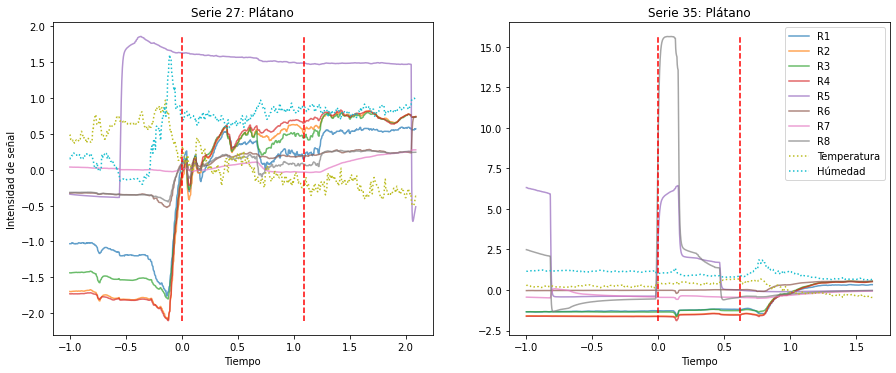

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(15,5.75))
for i, ax in zip([27,35], axs):
  curr_data = ts_data_sc[ts_data_sc['id']==i]
  for r in range(1,9):
    ax.plot(curr_data['time'], curr_data[f'R{r}'],label=f"R{r}",alpha=0.7)
  ax.plot(curr_data['time'],curr_data['Temp.'], ":", label="Temperatura")
  ax.plot(curr_data['time'],curr_data['Humidity'], ":", label="Húmedad")
  ax.plot([0,0], [min(curr_data[curr_data.columns[2:]].min()), max(curr_data[curr_data.columns[2:]].max())], "--", color="red")
  v=float(ts_meta.loc[ts_meta['id']==i]['dt'])
  ax.plot([v,v], [min(curr_data[curr_data.columns[2:]].min()), max(curr_data[curr_data.columns[2:]].max())], "--",color="red")
  ax.set_title(f"Serie {i}: Plátano")
  #ax.legend()
  ax.set_xlabel("Tiempo")
axs[0].set_ylabel("Intensidad de señal")
axs[-1].legend()
plt.savefig("sample_outliers.png", dpi=320)

In [ ]:
fig, axs = plt.subplots(20,5, figsize=(20,100))
i = 0
for axi in axs:
  for ax in axi:
    if i == 95:
      i+=1
      continue
    curr_data = ts_data_sc[ts_data_sc['id'] == i]
    for r in range(1,9):
      ax.plot(curr_data['time'], curr_data[f'R{r}'], label=f"R{r}", alpha=0.7)
    ax.plot(curr_data['time'], curr_data['Temp.'], ":", label="Temp")
    ax.plot(curr_data['time'], curr_data['Humidity'], ":", label="Humid")
    ax.plot([0,0], [min(curr_data[curr_data.columns[2:]].min()), max(curr_data[curr_data.columns[2:]].max())], "--",color="red")
    v=float(ts_meta.loc[ts_meta['id']==i]['dt'])
    ax.plot([v,v], [min(curr_data[curr_data.columns[2:]].min()), max(curr_data[curr_data.columns[2:]].max())], "--",color="red")
    ax.set_title(f"{str(ts_meta.loc[ts_meta['id']==i]['class'])}")
    ax.legend()
    i+=1

Output hidden; open in https://colab.research.google.com to view.

Las señales de temperatura y humedad se marcan con lineas punteadas, y las lineas rayadas horizontales marcan el intervalo temporal donde teóricamente está el estímulo.

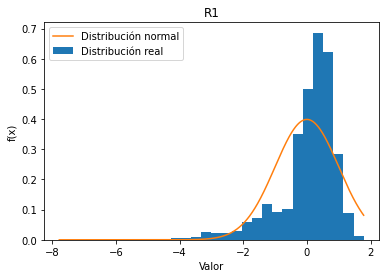

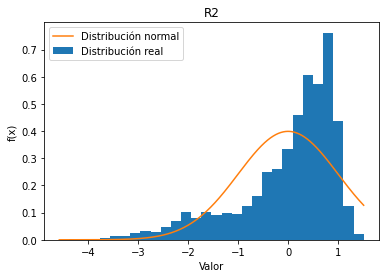

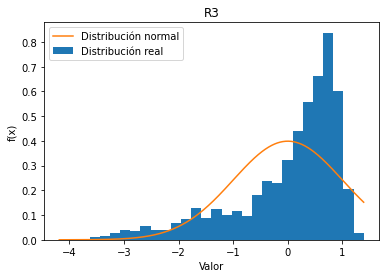

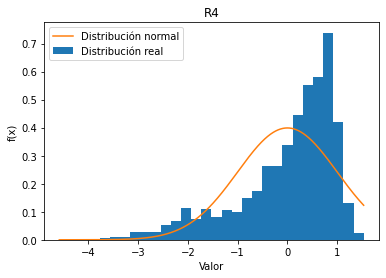

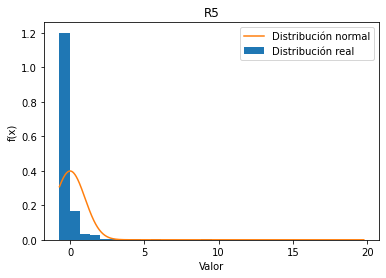

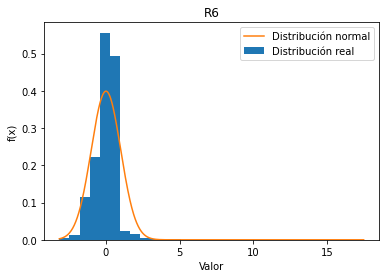

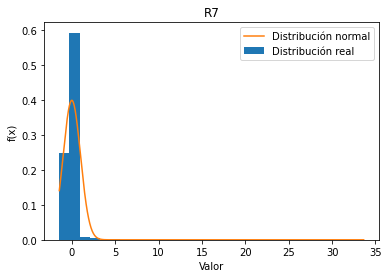

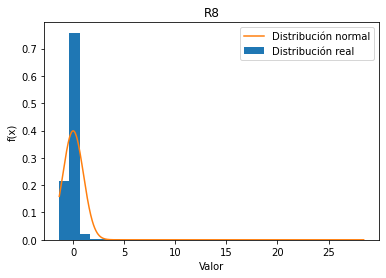

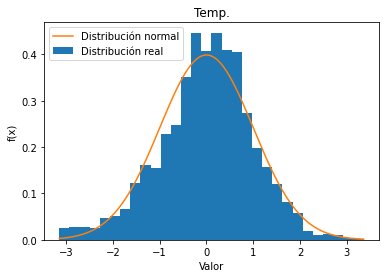

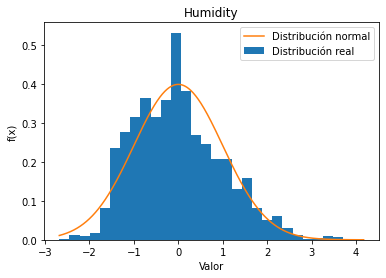

In [ ]:
for column in ts_data_sc:
  if column != "id" and column != "time":
    plt.hist(ts_data_sc.loc[:, column], bins = 30, density=True, label="Distribución real")

    rango = np.linspace(min(ts_data_sc.loc[:, column]), max(ts_data_sc.loc[:, column]), 1000)
    mu, sigma = np.mean(ts_data_sc.loc[:, column]), np.var(ts_data_sc.loc[:, column])
    plt.plot(rango, st.norm.pdf(rango, mu, sigma), label="Distribución normal")

    plt.title(column)
    plt.xlabel("Valor")
    plt.ylabel("f(x)")
    plt.legend()
    plt.show()
  

No todos los valores siguen una distribución exactamente normal, pero tampoco esta tan lejos (y esto igualmente es para los atributos en continuo, en ventanas prob sea mejor)

In [ ]:
ts_outliers = [24,26,27,33,35,36,49,68,86]

In [ ]:
print(ts_meta)
new_ts_meta = ts_meta.drop([24,26,27,33,35,36,49,68,86], axis= 0)


    id      date       class     t0    dt
0    0  07-04-15      banana  13.49  1.64
1    1  07-05-15        wine  19.61  0.54
2    2  07-06-15        wine  19.99  0.66
3    3  07-09-15      banana   6.49  0.72
4    4  07-09-15        wine  20.07  0.53
..  ..       ...         ...    ...   ...
94  94  09-10-15  background  14.94  0.79
96  96  09-14-15  background  13.37  0.94
97  97  09-15-15  background  14.25  0.72
98  98  09-16-15  background  14.41  0.71
99  99  09-17-15  background  11.93  0.68

[99 rows x 5 columns]


In [ ]:
print(new_ts_meta)

    id      date       class     t0    dt
0    0  07-04-15      banana  13.49  1.64
1    1  07-05-15        wine  19.61  0.54
2    2  07-06-15        wine  19.99  0.66
3    3  07-09-15      banana   6.49  0.72
4    4  07-09-15        wine  20.07  0.53
..  ..       ...         ...    ...   ...
94  94  09-10-15  background  14.94  0.79
96  96  09-14-15  background  13.37  0.94
97  97  09-15-15  background  14.25  0.72
98  98  09-16-15  background  14.41  0.71
99  99  09-17-15  background  11.93  0.68

[90 rows x 5 columns]


## [MMJ] - Selección de hiperparámetros de enventanado

**< RUN ONLY ONCE >**

### División de los datos en train y test. 

El test solo se usará al final para valorar la efectividad de los modelos con hiperparámetros ya seleccionados.

In [ ]:
ts_meta_train, ts_meta_test = skms.train_test_split(ts_meta, test_size=33)

ts_meta_train = ts_meta_train.reset_index()
ts_meta_test = ts_meta_test.reset_index()

ts_meta_train

,index,id,date,class,t0,dt
0,10,10,07-15-15,banana,12.70,1.18
1,22,22,07-26-15,banana,14.43,0.28
2,3,3,07-09-15,banana,6.49,0.72
3,9,9,07-15-15,banana,9.35,0.61
4,23,23,07-27-15,wine,8.37,0.94
...,...,...,...,...,...,...
61,45,45,08-25-15,wine,6.85,0.76
62,1,1,07-05-15,wine,19.61,0.54
63,47,47,08-26-15,banana,6.92,0.35
64,30,30,08-04-15,banana,7.80,0.48


In [ ]:
ts_train = ts_data_sc.loc[ts_data_sc['id'].isin(ts_meta_train['id'])]
ts_test = ts_data_sc.loc[ts_data_sc['id'].isin(ts_meta_test['id'])]

ts_train

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp.,Humidity
0,0,-0.999750,0.779562,0.904831,0.853984,0.899352,-0.090317,-0.820466,0.917566,0.855313,-1.169299,0.307931
1,0,-0.999472,0.779101,0.904767,0.853527,0.899235,-0.090338,-0.820799,0.917442,0.855334,-1.163661,0.303182
2,0,-0.999194,0.777949,0.905024,0.853241,0.899177,-0.090355,-0.821011,0.917331,0.855355,-1.157359,0.298910
3,0,-0.998916,0.777373,0.905024,0.853241,0.899235,-0.090371,-0.821223,0.917279,0.855419,-1.151721,0.295011
4,0,-0.998627,0.776567,0.905152,0.853469,0.899352,-0.090382,-0.821465,0.917283,0.855570,-1.146636,0.291506
...,...,...,...,...,...,...,...,...,...,...,...,...
928986,99,1.675182,0.503447,1.041014,1.028350,1.195868,-0.136169,0.375476,0.281690,0.347078,0.491773,-0.708208
928987,99,1.675460,0.504829,1.040437,1.028579,1.196160,-0.136098,0.375234,0.281673,0.347121,0.495090,-0.710468
928988,99,1.675738,0.505751,1.040372,1.028636,1.196277,-0.136028,0.374901,0.281697,0.347081,0.498075,-0.712521
928989,99,1.676016,0.505635,1.040501,1.028807,1.196394,-0.135984,0.374810,0.281756,0.347087,0.500839,-0.714367


In [ ]:
ts_meta_train.to_csv("ts_meta_train.csv")
ts_meta_test.to_csv("ts_meta_test.csv")
ts_train.to_csv("ts_train.csv")
ts_test.to_csv("ts_test.csv")

In [ ]:
ts_meta_train = pd.read_csv("ts_meta_train.csv", index_col=0)
ts_meta_test = pd.read_csv("ts_meta_test.csv", index_col=0)
ts_train = pd.read_csv("ts_train.csv", index_col=0)
ts_test = pd.read_csv("ts_test.csv", index_col=0)

### Selección de hiperparámetros de la ventana

Para una secuencia de $Δt$s que cubren el intervalo de dt encontrado en los metadatos (y para 2 opciones de delay sugeridas por las gráficas de las señales) se valida mediante CV del dataset de training el error cometido por LDA de 2 formas:

1. Error cometido en la clasificación de las ventanas de test generadas. Esta medida es problemática porque si el $Δt$ es muy grande se clasifican como estímulo ventanas que solo incluyen regiones muy pequeñas (=> casi todas las ventanas generadas en una serie aparecen clasificadas como estímulo, la separación se hace más sencilla porque hay menos ventanas background de series con estímulo y porque con mayor intervalo se detectan mejor, ...)

2. Error cometido al comparar la clase en función del tiempo de la serie original y la reconstrucción que se hace en base a las ventanas (cuando se clasifica una ventana se asigna su clase a un intervalo alrededor de su punto medio que no solapa con el resto de ventanas). Esta medida es más apropiada porque tiene en cuenta la resolución temporal.

Además, las ventanas pequeñas tienden a tener menor error porque los priors se desbalancean hacia ventanas de background y es más facil resolver el problema solo prediciendo background, por lo que se considera en el error 2. un valor por separado para cuando la clase real es background y otro para cuando la clase real es estímulo.



In [ ]:
def window_data(ts_data, ts_meta, offset, dt, delay):
  win_data = []

  for id in ts_meta['id']:
    id_data = ts_data.loc[ts_data['id']==id]
    id_meta = ts_meta.loc[ts_meta['id']==id]
    starts = np.arange(id_data['time'].min(), id_data['time'].max(), offset)

    for start in starts:
      window_data = id_data.loc[np.logical_and(id_data['time'] >= start, id_data['time'] < start + dt) ]

      window_info = {}
      for atrib in id_data.columns[2:]:
        window_info[atrib+'_min'] = window_data[atrib].min()
        window_info[atrib+'_max'] = window_data[atrib].max()
        window_info[atrib+'_mean'] = window_data[atrib].mean()
        window_info[atrib+'_std'] = window_data[atrib].std()

      int1, int2 = pd.Interval(start, start + dt), pd.Interval(delay, delay + id_meta['dt'].values[0])
      window_info['class'] = (1 if id_meta['class'].values[0] == 'wine' else 2) if int1.overlaps(int2) else 0
      window_info['id'] = id
      window_info['start'] = start
      
      win_data.append(window_info)

  return pd.DataFrame(win_data).dropna()

In [ ]:
hparams = [ (dt, delay) for dt in [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5] for delay in [0.1, 0.2] ]

offset = 0.1

In [ ]:
# CV error outputs
lda_win_confm = []
lda_win_errors = []
lda_ts_back_errors = []
lda_ts_sti_errors = []
lda_ts_sim_errors = []

# KFold split
skf = skms.KFold(n_splits=5)
skf.get_n_splits(ts_meta_train)

folds = skf.split(ts_meta_train)
for iter in tqdm(range(5), desc="Fold progress..."):

  fit_idx, val_idx = next(folds)

  # Fit and Val for each Fold
  ts_meta_fit = ts_meta_train.loc[fit_idx]
  ts_meta_val = ts_meta_train.loc[val_idx]
  ts_fit = ts_train.loc[ts_train['id'].isin(ts_meta_fit['id'])]
  ts_val = ts_train.loc[ts_train['id'].isin(ts_meta_val['id'])]

  for hi in range(len(hparams)):
    dt, delay = hparams[hi]

    # Fit data windowing
    win_data_fit = window_data(ts_fit, ts_meta_fit, offset, dt, delay)
    win_data_fit_sc = ts_sc.fit_transform(win_data_fit[win_data_fit.columns[:-3]])

    # LDA fit
    win_lda = LinearDiscriminantAnalysis(priors=[1/3,1/3,1/3])
    win_lda = win_lda.fit(win_data_fit_sc, win_data_fit['class'])

    # Val data windowing
    win_data_val = window_data(ts_val, ts_meta_val, offset, dt, delay)
    win_data_val_sc = ts_sc.fit_transform(win_data_val[win_data_val.columns[:-3]])

    # LDA predictions for all windows, confusion matrix and error rate 
    win_preds_all = win_lda.predict(win_data_val_sc)
    confm = confusion_matrix(win_data_val['class'], win_preds_all)
    lda_win_confm.append({'dt':dt, 'delay':delay, 'confm':confm})
    lda_win_errors.append({'dt':dt, 'delay':delay, 'error': np.mean(win_data_val['class']!=win_preds_all)})

    # TS reconstruction and errors
    back_errors = []
    sti_errors = []
    sim_errors = []

    for id in ts_meta_val['id']:
      win_val_i = win_data_val.loc[win_data_val['id']==id]
      win_val_sc_i = win_data_val_sc[win_data_val['id']==id, :]

      ts_meta_val_i = ts_meta_val.loc[ts_meta_val['id']==id]
      DT_i = ts_meta_val_i['dt'].values[0]
      class_i = ts_meta_val_i['class'].values[0]
      class_i = (1 if class_i=='wine' else (2 if class_i=='banana' else 0))

      ts_val_i = ts_val.loc[ts_val['id'] == id]
      tmin = list(ts_val_i['time'])[0]
      tmax = list(ts_val_i['time'])[-1]
      times = np.linspace(tmin,tmax,5000)
      reals = np.logical_and(times >= delay, times < delay+DT_i).astype(int)*class_i
      preds = np.zeros_like(times)

      win_preds_i = win_lda.predict(win_val_sc_i)
      for j,idx in enumerate(win_val_i.index):
        start = win_val_i.loc[idx]['start']
        low_bound = (start + dt/2 - offset/2) if j>0 else tmin
        hig_bound = (start + dt/2 + offset/2) if j<len(win_val_i.index) else tmax
        preds[np.logical_and(times >= low_bound, times < hig_bound)] = win_preds_i[j]

      errors_i = reals!=preds
      back_loc = np.logical_or(times < delay, times >= delay+DT_i)
      back_error = 1 if not np.any(back_loc) else (np.mean(errors_i[back_loc]))
      sti_loc = np.logical_and(times >= delay, times < delay+DT_i)
      sti_error = 1 if not np.any(sti_loc) else (np.mean(errors_i[sti_loc]))

      back_errors.append(back_error)
      sti_errors.append(sti_error)
      sim_errors.append(np.mean([back_error, sti_error]))
    
    lda_ts_back_errors.append({'dt':dt, 'delay':delay, 'error': np.mean(back_errors)})
    lda_ts_sti_errors.append({'dt':dt, 'delay':delay, 'error': np.mean(sti_errors)})
    lda_ts_sim_errors.append({'dt':dt, 'delay':delay, 'error': np.mean(sim_errors)})

Fold progress...: 100%|██████████| 5/5 [07:46<00:00, 93.28s/it]


In [ ]:
lda_win_errors = pd.DataFrame(lda_win_errors)
lda_ts_back_errors = pd.DataFrame(lda_ts_back_errors)
lda_ts_sti_errors = pd.DataFrame(lda_ts_sti_errors)
lda_ts_sim_errors = pd.DataFrame(lda_ts_sim_errors)

lda_win_mean_errors = lda_win_errors.groupby(['dt','delay']).mean()
lda_ts_back_mean_errors = lda_ts_back_errors.groupby(['dt','delay']).mean()
lda_ts_sti_mean_errors = lda_ts_sti_errors.groupby(['dt','delay']).mean()
lda_ts_sim_mean_errors = lda_ts_sim_errors.groupby(['dt','delay']).mean()

lda_win_std_errors = lda_win_errors.groupby(['dt','delay']).std()
lda_ts_back_std_errors = lda_ts_back_errors.groupby(['dt','delay']).std()
lda_ts_sti_std_errors = lda_ts_sti_errors.groupby(['dt','delay']).std()
lda_ts_sim_std_errors = lda_ts_sim_errors.groupby(['dt','delay']).std()

#### Análisis de error por ventana

Text(0.5, 1.0, 'Window LDA error')

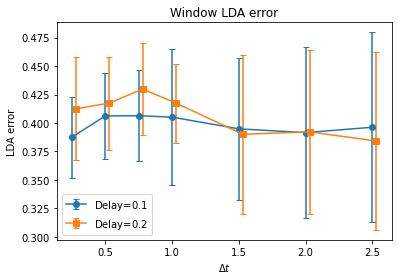

In [ ]:
temp = lda_win_mean_errors.unstack()
temp2 = lda_win_std_errors.unstack()

del1_means = temp['error'][0.1]
del2_means = temp['error'][0.2]
del1_stds = temp2['error'][0.1]
del2_stds = temp2['error'][0.2]

plt.errorbar(del1_means.index, del1_means, del1_stds, marker='o', label="Delay=$0.1$", capsize=3)
plt.errorbar(del2_means.index+0.03, del2_means, del2_stds, marker='s', label="Delay=$0.2$", capsize=3)
plt.legend()
plt.xlabel("$\Delta t$")
plt.ylabel("LDA error")
plt.title("Window LDA error")

Hipótesis para explicar los resultados:

* Con ventanas demasiado pequeñas la separación de las clases es más complicada pero el desequilibrio entre ventanas background y estímulo permite menor error prediciendo siempre background.

* Con ventanas demasiado grandes la separación de clases es muy fácil pero vamos a tener casi todas las ventanas de una serie con estimulo clasificadas a ese estimulo y vamos a perder capacidad de detección en los bordes.

***Matriz de confusión para $Δt=0.25$ y Delay$=0.1$:***

Text(0.5, 1.0, 'Matriz confusión')

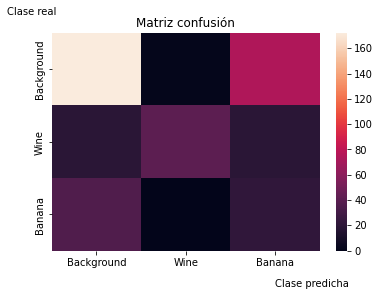

In [ ]:
class_key = ['Background','Wine','Banana']
tmp = [line['confm'] for line in lda_win_confm if line['delay']==0.1 and line['dt']==0.25][0]
tmp = pd.DataFrame(tmp, index=class_key, columns=class_key)
sn.heatmap(tmp)
plt.text(-0.5,-0.25,"Clase real")
plt.text(2.5,3.5,"Clase predicha")
plt.title("Matriz confusión")

Tenemos un error relativamente bajo porque la mayoría del color se concentra en zonas buenas (back <-> back y wine <-> wine) aunque tenemos tambien una confusion importante entre banana y background.

In [ ]:
tmp = tmp.div(tmp.sum(axis=1), axis=0)
print("Matriz de confusión normalizada")
tmp.round(decimals=3)

Matriz de confusión normalizada


,Background,Wine,Banana
Background,0.694,0.008,0.298
Wine,0.241,0.519,0.241
Banana,0.621,0.000,0.379


Sin embargo, al mirar la matriz relativa vemos que el error en vino y banana es de hecho bastante alto. Conseguimos un error aparentemente bajo porque background en general es mucho más abundante.

***Matriz de confusión para $Δt=2.5$ y Delay$=0.2$:***

Text(0.5, 1.0, 'Matriz confusión')

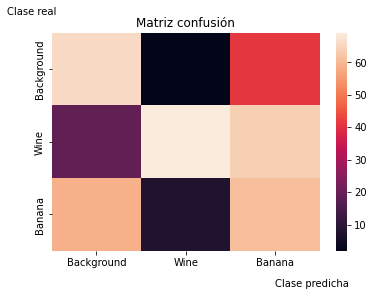

In [ ]:
class_key = ['Background','Wine','Banana']
tmp = [line['confm'] for line in lda_win_confm if line['delay']==0.2 and line['dt']==2.5][0]
tmp = pd.DataFrame(tmp, index=class_key, columns=class_key)
sn.heatmap(tmp)
plt.text(-0.5,-0.25,"Clase real")
plt.text(2.5,3.5,"Clase predicha")
plt.title("Matriz confusión")

Volvemos a tener una confusión importante entre banana y background pero el error es ligeramente menor porque ahora tenemos aún más color concentrado en la diagonal

In [ ]:
tmp = tmp.div(tmp.sum(axis=1), axis=0)
print("Matriz de confusión normalizada")
tmp.round(decimals=3)

Matriz de confusión normalizada


,Background,Wine,Banana
Background,0.606,0.018,0.376
Wine,0.125,0.454,0.421
Banana,0.461,0.062,0.477


En este caso la confusión entre background y banana sigue siendo importante pero se puede comprobar que en general la separación de las clases es algo mejor.

#### Análisis del error por reconstrucción de la serie temporal

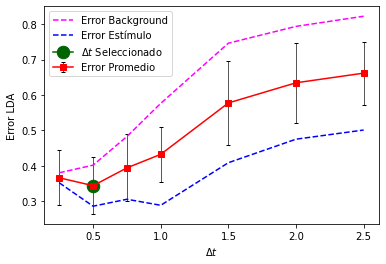

In [ ]:
temp3 = lda_ts_back_mean_errors.unstack()
temp4 = lda_ts_back_std_errors.unstack()
temp5 = lda_ts_sti_mean_errors.unstack()
temp6 = lda_ts_sti_std_errors.unstack()
temp7 = lda_ts_sim_mean_errors.unstack()
temp8 = lda_ts_sim_std_errors.unstack()

back_means = temp3['error'][0.1]
back_stds = temp4['error'][0.1]
sti_means = temp5['error'][0.1]
sti_stds = temp6['error'][0.1]
sim_means = temp7['error'][0.1]
sim_stds = temp8['error'][0.1]

plt.errorbar(sim_means.index, sim_means, sim_stds, marker='s', label="Error Promedio", capsize=2, color="red", ecolor="black", elinewidth=0.65)
plt.plot(back_means.index, back_means, ls="--", label="Error Background", color="magenta")
plt.plot(sti_means.index, sti_means, ls="--", label="Error Estímulo", color="blue")
plt.plot(0.5, sim_means[0.5], color="darkgreen", marker='o', markersize=12.5, label="$\Delta t$ Seleccionado")
plt.legend()
plt.xlabel("$\Delta t$")
plt.ylabel("Error LDA")
#plt.title("Delay$=0.1$")
plt.savefig("lda_error_window_hparams.png", dpi=320)

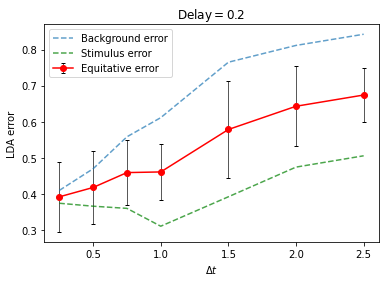

In [ ]:
back_means = temp3['error'][0.2]
back_stds = temp4['error'][0.2]
sti_means = temp5['error'][0.2]
sti_stds = temp6['error'][0.2]
sim_means = temp7['error'][0.2]
sim_stds = temp8['error'][0.2]

plt.errorbar(sim_means.index, sim_means, sim_stds, marker='o', label="Equitative error", capsize=2, color="red", ecolor="black", elinewidth=0.65)
plt.plot(back_means.index, back_means, ls="--", label="Background error", alpha=0.7)
plt.plot(sti_means.index, sti_means, ls="--", label="Stimulus error", color="green", alpha=0.7)
plt.legend()
plt.xlabel("$\Delta t$")
plt.ylabel("LDA error")
plt.title("Delay$=0.2$")
plt.savefig("lda_error_window_hparams_delay0.2.png", dpi=320)

$\Delta t=0.5$ parece ser un valor con un buen compromiso entre el error general de estímulo y el error general de background. También sería el valor seleccionado de acuerdo al error equitativo (promedio entre error de background y de estímulo pero dentro de cada serie; no estoy seguro de si es diferente del promedio entre el background y el estímulo general pero parece que sí).

Por otro lado Delay$=0.1$ es mejor en general en todos los casos.

### $\Delta t=0.5$, Delay=$0.1$



In [ ]:
offset=0.1
dt=0.5
delay=0.1

ts_sc = StandardScaler()

win_data_train = window_data(ts_train, ts_meta_train, offset, dt, delay)
win_data_train = win_data_train.reset_index(drop=True)
win_data_train_sc = ts_sc.fit_transform(win_data_train[win_data_train.columns[:-3]])

win_data_test = window_data(ts_test, ts_meta_test, offset, dt, delay)
win_data_test = win_data_test.reset_index(drop=True)
win_data_test_sc = ts_sc.fit_transform(win_data_test[win_data_test.columns[:-3]])

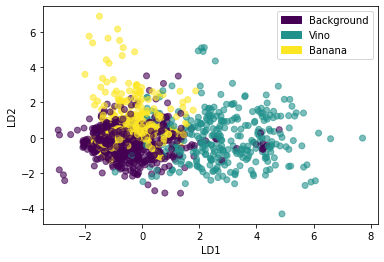

In [ ]:
win_lda = LinearDiscriminantAnalysis()
win_lda.fit(win_data_train_sc, win_data_train['class'])

lda_win_data_train = win_lda.transform(win_data_train_sc)

cmap = plt.get_cmap("viridis")
plt.scatter(lda_win_data_train[:,0], lda_win_data_train[:,1], c=win_data_train['class'], alpha=0.6, cmap=cmap)
plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['Background', "Vino", "Banana"])
#plt.title("$\Delta t=0.5$, Delay$=0.1$ // Training")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.savefig("LDA_sep_train.png", dpi=320)

Separación apreciable aunque no perfecta de las 3 clases.

Text(0, 0.5, 'LD2')

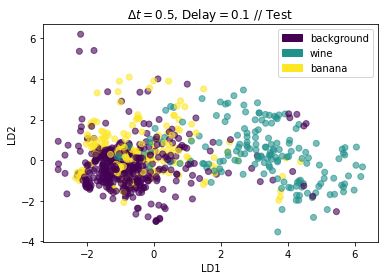

In [ ]:
lda_win_data_test = win_lda.transform(win_data_test_sc)

cmap = plt.get_cmap("viridis")
plt.scatter(lda_win_data_test[:,0], lda_win_data_test[:,1], c=win_data_test['class'], alpha=0.6, cmap=cmap)
plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['background', "wine", "banana"])
plt.title("$\Delta t=0.5$, Delay$=0.1$ // Test")
plt.xlabel("LD1")
plt.ylabel("LD2")

Lógicamente en test la separación no es tan buena. En cualquier caso hacer como si no se hubiera visto el test, para no influir a los resultados.

In [ ]:
win_data_train_sc = pd.DataFrame(win_data_train_sc, columns=win_data_train.columns[:-3])
win_data_test_sc = pd.DataFrame(win_data_test_sc, columns=win_data_test.columns[:-3])
lda_win_data_train = pd.DataFrame(lda_win_data_train, columns=["LD1","LD2"])
lda_win_data_test = pd.DataFrame(lda_win_data_test, columns=["LD1","LD2"])

for col in list(win_data_train.columns[-3:]):
  win_data_train_sc.insert(loc=len(win_data_train_sc.columns),
                           column=col,
                           value=win_data_train[col])
  win_data_test_sc.insert(loc=len(win_data_test_sc.columns),
                           column=col,
                           value=win_data_test[col])
  lda_win_data_train.insert(loc=len(lda_win_data_train.columns),
                           column=col,
                           value=win_data_train[col])
  lda_win_data_test.insert(loc=len(lda_win_data_test.columns),
                           column=col,
                           value=win_data_test[col])
  
  if col == "class" or col=="id":
    win_data_train_sc[col] = win_data_train_sc[col].astype(int)
    win_data_test_sc[col] = win_data_test_sc[col].astype(int)
    lda_win_data_train[col] = lda_win_data_train[col].astype(int)
    lda_win_data_test[col] = lda_win_data_test[col].astype(int)

win_data_train_sc.to_csv("win_data_train_sc.csv")
win_data_test_sc.to_csv("win_data_test_sc.csv")
lda_win_data_train.to_csv("lda_win_data_train.csv")
lda_win_data_test.to_csv("lda_win_data_test.csv")

### Discusión adicional de selección de hiperparámetros de ventana

Aquí se muestra otra gráfica del error en la clasificación de las ventanas cuando se usó LDA con priors libres (inferidos a partir de los datos) En este caso las ventanas pequeñas son más "rentables" que en el presentado en el cuaderno porque se permitía al modelo LDA favorecer a la clase más abundante (predecir background e ignorar el estímulo)

![](https://drive.google.com/uc?export=view&id=1I_VIn5G1fSflCgMiriXDpcbvL1NEKZKl)

Esta otra imagen muestra la separación que hay en training con $Δt=0.25$, donde comprobamos que estan muy mal separadas:

![](https://drive.google.com/uc?export=view&id=1shnPRrav8r_0VPJ2SSfU9a8nKKbnE3UW)

Aunque en principio no hay ninguna curva de error que justifique su uso, mostramos también la separación en training con $\Delta t=2.5$ para comprobar que efectivamente, estan muy bien separadas (el problema es que tenemos poca resolución temporal)

![](https://drive.google.com/uc?export=view&id=15-yM5eEi-AAp1NbWPUl3oauc3Uooeu6b)

### Ampliación de la forma en que se valora el error por reconstrucción de series temporales

Text(0.5, 1.0, 'Comparación entre asignación de clase original y predicción')

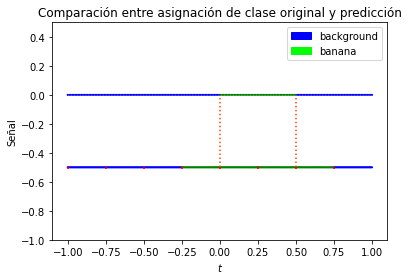

In [ ]:
t = np.linspace(-1,1,200)

cmap2 = plt.get_cmap("brg")
plt.scatter(t, np.zeros(len(t)), c=np.where(np.logical_and(t>=0,t<0.5), "g","b"), s=1)
starts = np.linspace(-1,0.75,8)
dt = np.diff(starts)[0]
for start in starts:
  t2 = np.linspace(start,start+dt,50)
  plt.scatter(t2, np.zeros(len(t2))-0.5, c=["b" if (start+dt<0 or start>0.5) else "g" for x in range(len(t2))], s=1)
  plt.plot([start, start], [-0.51,-0.49], "--", color="r")
plt.plot([0,0], [-0.5,0], ":", color="orangered")
plt.plot([0.5,0.5], [-0.5,0], ":", color="orangered")
plt.legend([mpatches.Patch(color=cmap2(b)) for b in [0,1.0]],
           ['background',"banana"])
plt.ylim(-1,0.5)
plt.xlabel("$t$")
plt.ylabel("Señal")
plt.title("Comparación entre asignación de clase original y predicción")

Aunque en realidad las ventanas que utilizamos son solapantes con un offset muy pequeño, las ventanas que incluyen al menos una cantidad mínima del impulso son clasificadas como tal (como se ilustra en la imagen)

Text(0.5, 1.0, 'Ventanas demasiado grandes')

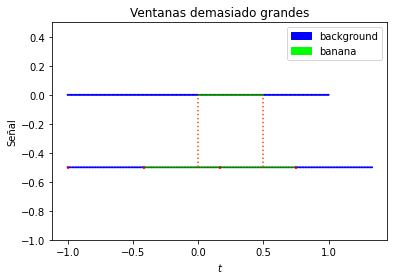

In [ ]:
t = np.linspace(-1,1,200)

cmap2 = plt.get_cmap("brg")
plt.scatter(t, np.zeros(len(t)), c=np.where(np.logical_and(t>=0,t<0.5), "g","b"), s=1)
starts = np.linspace(-1,0.75,4)
dt = np.diff(starts)[0]
for start in starts:
  t2 = np.linspace(start,start+dt,50)
  plt.scatter(t2, np.zeros(len(t2))-0.5, c=["b" if (start+dt<0 or start>0.5) else "g" for x in range(len(t2))], s=1)
  plt.plot([start, start], [-0.51,-0.49], "--", color="r")
plt.plot([0,0], [-0.5,0], ":", color="orangered")
plt.plot([0.5,0.5], [-0.5,0], ":", color="orangered")
plt.legend([mpatches.Patch(color=cmap2(b)) for b in [0,1.0]],
           ['background',"banana"])
plt.ylim(-1,0.5)
plt.xlabel("$t$")
plt.ylabel("Señal")
plt.title("Ventanas demasiado grandes")

La consecuencia es que para ventanas demasiado grandes la mayoría de las ventanas se asignan como estímulo y aunque la predicción sea perfecta vamos a perder resolución a la hora de saber en que punto empieza y termina el estímulo

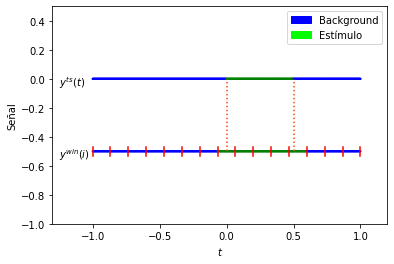

In [ ]:
t = np.linspace(-1,1,2000)

cmap2 = plt.get_cmap("brg")
plt.scatter(t, np.zeros(len(t)), c=np.where(np.logical_and(t>=0,t<0.5), "g","b"), s=1)
starts = np.linspace(-1,1,16)
dt = np.diff(starts)[0]
for start in starts[:-1]:
  t2 = np.linspace(start,start+dt,50)
  plt.scatter(t2, np.zeros(len(t2))-0.5, c=["b" if (start+dt<0 or start>0.5) else "g" for x in range(len(t2))], s=1)
  plt.plot([start, start], [-0.53,-0.47], "-", color="r")
plt.plot([starts[-1], starts[-1]], [-0.53,-0.47], "-", color="r")
plt.plot([0,0], [-0.5,0], ":", color="orangered")
plt.plot([0.5,0.5], [-0.5,0], ":", color="orangered")
plt.legend([mpatches.Patch(color=cmap2(b)) for b in [0,1.0]],
           ['Background',"Estímulo"])
plt.text(-1.25,-0.05,"$y^{ts}(t)$")
plt.text(-1.25,-0.55,"$y^{win}(i)$")
plt.ylim(-1,0.5)
plt.xlim(-1.3,1.2)
plt.xlabel("$t$")
plt.ylabel("Señal")
#plt.title("Ventanas pequeñas más resolución")
plt.savefig("ts_to_win_fig.png", dpi=320)

In [ ]:
t = np.linspace(-1,1,2000)

cmap2 = plt.get_cmap("brg")
plt.scatter(t, np.zeros(len(t)), c=np.where(np.logical_and(t>=0,t<0.5), "g","b"), s=1)
starts = np.linspace(-1,1,16)
dt = np.diff(starts)[0]
for start in starts[:-1]:
  t2 = np.linspace(start,start+dt,50)
  plt.scatter(t2, np.zeros(len(t2))-0.5, c=["b" if (start+dt<0 or start>0.5) else "g" for x in range(len(t2))], s=1)
  plt.plot([start, start], [-0.53,-0.47], "-", color="r")
plt.plot([starts[-1], starts[-1]], [-0.53,-0.47], "-", color="r")
plt.plot([0,0], [-0.5,0], ":", color="orangered")
plt.plot([0.5,0.5], [-0.5,0], ":", color="orangered")
plt.legend([mpatches.Patch(color=cmap2(b)) for b in [0,1.0]],
           ['Background',"Estímulo"])
plt.text(-1.25,-0.05,"$\hat{y}^{win}(i)$")
plt.text(-1.25,-0.55,"$\hat{y}^{ts}(t)$")
plt.ylim(-1,0.5)
plt.xlim(-1.3,1.2)
plt.xlabel("$t$")
plt.ylabel("Señal")
#plt.title("Ventanas pequeñas más resolución")
#plt.savefig("win_to_ts_fig.png", dpi=320)

Con ventanas más pequeñas la precisión es mayor pero se puede reducir el error simplemente prediciendo background, al ser más abundante.

Text(0.5, 1.0, 'Ventanas pequeñas más resolución')

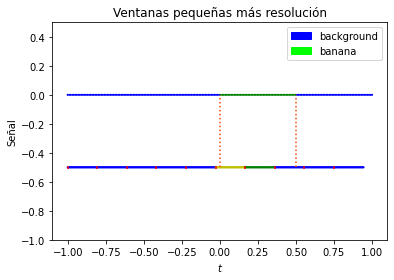

In [ ]:
t = np.linspace(-1,1,200)

cmap2 = plt.get_cmap("brg")
plt.scatter(t, np.zeros(len(t)), c=np.where(np.logical_and(t>=0,t<0.5), "g","b"), s=1)
starts = np.linspace(-1,0.75,10)
dt = np.diff(starts)[0]
for start in starts:
  t2 = np.linspace(start,start+dt,50)
  plt.scatter(t2, np.zeros(len(t2))-0.5, c=["b" if (start+dt<0 or start>0.3) else ("g" if (start< -0.03 or start>-0.01) else "y") for x in range(len(t2))], s=1)
  plt.plot([start, start], [-0.51,-0.49], "--", color="r")
plt.plot([0,0], [-0.5,0], ":", color="orangered")
plt.plot([0.5,0.5], [-0.5,0], ":", color="orangered")
plt.legend([mpatches.Patch(color=cmap2(b)) for b in [0,1.0]],
           ['background',"banana"])
plt.ylim(-1,0.5)
plt.xlabel("$t$")
plt.ylabel("Señal")
plt.title("Ejemplo de error")

En este caso mostraríamos una posible predicción sobre el set de ventanas que tiene una serie.

Además de tener en cuenta las ventanas incorrectamente clasificadas (en este caso serían 2), hay que tener en cuenta la proporción de la señal en background mal clasificada (en este caso una parte muy pequeña al principio de la ventana amarilla) y de la señal en estimulo (la mayoria de la ventana amarilla y la verde)

El error en este formato se calcula, por tanto, como el % del tiempo sobre el que las clases asignadas a ambas series difieren. Para eso es necesario un método para asignar clases a la serie de tiempo con ventanas solapantes (en algún momento incluiré otra ilustración o algo asi). 

Además, para evitar que el error de background ahogue al de estímulo los consideramos a ambos por separado (y/o sacamos una media de su error para que ambos tengan peso 0.5)

### Datasets enventanados outlier free (de momento solo filtrando outliers de las series temporales

In [ ]:
ts_meta_train

,index,id,date,class,t0,dt
0,10,10,07-15-15,banana,12.70,1.18
1,22,22,07-26-15,banana,14.43,0.28
2,3,3,07-09-15,banana,6.49,0.72
3,9,9,07-15-15,banana,9.35,0.61
4,23,23,07-27-15,wine,8.37,0.94
...,...,...,...,...,...,...
61,45,45,08-25-15,wine,6.85,0.76
62,1,1,07-05-15,wine,19.61,0.54
63,47,47,08-26-15,banana,6.92,0.35
64,30,30,08-04-15,banana,7.80,0.48


In [ ]:
of_ts_meta_train = ts_meta_train.loc[np.logical_not(ts_meta_train['id'].isin(ts_outliers))]
of_ts_meta_test = ts_meta_test.loc[np.logical_not(ts_meta_test['id'].isin(ts_outliers))]
of_ts_train = ts_train.loc[np.logical_not(ts_train['id'].isin(ts_outliers))]
of_ts_test = ts_test.loc[np.logical_not(ts_test['id'].isin(ts_outliers))]

In [ ]:
of_ts_meta_train.to_csv("of_ts_meta_train.csv")
of_ts_meta_test.to_csv("of_ts_meta_test.csv")
of_ts_train.to_csv("of_ts_train.csv")
of_ts_test.to_csv("of_ts_test.csv")

In [ ]:
offset=0.1
dt=0.5
delay=0.1

ts_sc = StandardScaler()

of_win_data_train = window_data(of_ts_train, of_ts_meta_train, offset, dt, delay)
of_win_data_train = of_win_data_train.reset_index(drop=True)
of_win_data_train_sc = ts_sc.fit_transform(of_win_data_train[of_win_data_train.columns[:-3]])

of_win_data_test = window_data(of_ts_test, of_ts_meta_test, offset, dt, delay)
of_win_data_test = of_win_data_test.reset_index(drop=True)
of_win_data_test_sc = ts_sc.fit_transform(of_win_data_test[of_win_data_test.columns[:-3]])

In [ ]:
of_win_data_train_sc = pd.DataFrame(of_win_data_train_sc, columns=of_win_data_train.columns[:-3])
of_win_data_test_sc = pd.DataFrame(of_win_data_test_sc, columns=of_win_data_test.columns[:-3])

for col in list(of_win_data_train.columns[-3:]):
  of_win_data_train_sc.insert(loc=len(of_win_data_train_sc.columns),
                           column=col,
                           value=of_win_data_train[col])
  of_win_data_test_sc.insert(loc=len(of_win_data_test_sc.columns),
                           column=col,
                           value=of_win_data_test[col])
  
  if col == "class" or col=="id":
    of_win_data_train_sc[col] = of_win_data_train_sc[col].astype(int)
    of_win_data_test_sc[col] = of_win_data_test_sc[col].astype(int)

of_win_data_train_sc.to_csv("of_win_data_train_sc.csv")
of_win_data_test_sc.to_csv("of_win_data_test_sc.csv")

## Datasets enventanados < RUN ME >

También los de time series, comentados porque en principio ya no hacen falta.

In [3]:
#ts_meta_train = pd.read_csv("ts_meta_train.csv", index_col=0)
#ts_meta_test = pd.read_csv("ts_meta_test.csv", index_col=0)
#ts_train = pd.read_csv("ts_train.csv", index_col=0)
#ts_test = pd.read_csv("ts_test.csv", index_col=0)

win_data_train_sc = pd.read_csv("win_data_train_sc.csv", index_col=0)
win_data_test_sc = pd.read_csv("win_data_test_sc.csv", index_col=0)

lda_win_data_train = pd.read_csv("lda_win_data_train.csv", index_col=0)
lda_win_data_test = pd.read_csv("lda_win_data_test.csv", index_col=0)

In [ ]:
of_win_data_train_sc = pd.read_csv("of_win_data_train_sc.csv", index_col=0)
of_win_data_test_sc = pd.read_csv("of_win_data_test_sc.csv", index_col=0)

**< NO NEED TO RUN THIS ONE >**

In [ ]:
# Versión que incluye train y test para aplicar métodos no supervisados como PCA

# A la hora de entrenarlo fiteamos con esta versión conjunta y luego podemos 
# transformar los datasets por separado para que esten divididos igual

win_data_sc = pd.concat([win_data_train_sc, win_data_test_sc])
of_win_data_sc = pd.concat([of_win_data_train_sc, of_win_data_test_sc])

## [AAF] - Comparación de LDA entrenado en ventanas puras y en ventanas no puras

Creación del dataset puro:

In [ ]:
def window_est(ts_data, ts_meta):
  win_data = []

  for id in ts_meta['id']:
    id_data = ts_data.loc[ts_data['id']==id]
    id_meta = ts_meta.loc[ts_meta['id']==id]
    window_data = id_data.loc[np.logical_and(id_data['time'] >= 0, id_data['time'] < np.array(id_meta['dt'])[0]) ]
    window_info = {}

    for atrib in id_data.columns[2:]:
      window_info[atrib+'_min'] = window_data[atrib].min()
      window_info[atrib+'_max'] = window_data[atrib].max()
      window_info[atrib+'_mean'] = window_data[atrib].mean()
      window_info[atrib+'_std'] = window_data[atrib].std()

    window_info['class'] = 1 if id_meta['class'].values[0] == 'wine' else (2 if id_meta['class'].values[0] == 'banana' else 0)
    window_info['id'] = id
    window_info['start'] = start
    
    win_data.append(window_info)

  return pd.DataFrame(win_data).dropna()

In [ ]:
win_est_train = window_est(ts_train, ts_meta_train)
win_est_train = win_est_train.reset_index(drop=True)
ts_sc.fit(win_est_train[win_est_train.columns[:-3]])
win_est_train_sc = ts_sc.transform(win_est_train[win_est_train.columns[:-3]])


win_est_test = window_est(ts_test, ts_meta_test)
win_est_test = win_est_test.reset_index(drop=True)
win_est_test_sc = ts_sc.transform(win_est_test[win_est_test.columns[:-3]])

win_est_sc = pd.concat([win_est_train_sc, win_est_test_sc])

Validación cruzada

In [ ]:
# CV error outputs
lda_win_confm = []
lda_win_errors = []
lda_ts_back_errors = []
lda_ts_sti_errors = []
lda_ts_sim_errors = []

# KFold split
skf = skms.KFold(n_splits=5)
skf.get_n_splits(ts_meta_train)

#Scaler
ts_sc = StandardScaler()

folds = skf.split(ts_meta_train)
for iter in tqdm(range(5), desc="Fold progress..."):

  fit_idx, val_idx = next(folds)

  # Fit and Val for each Fold
  ts_meta_fit = ts_meta_train.loc[fit_idx]
  ts_meta_val = ts_meta_train.loc[val_idx]
  ts_fit = ts_train.loc[ts_train['id'].isin(ts_meta_fit['id'])]
  ts_val = ts_train.loc[ts_train['id'].isin(ts_meta_val['id'])]

  for hi in range(len(hparams)):
    dt, delay = hparams[hi]

    # Fit data windowing
    win_est_fit = window_est(ts_fit, ts_meta_fit)
    win_est_fit_sc = ts_sc.fit_transform(win_est_fit[win_est_fit.columns[:-3]])

    # LDA fit
    win_est_lda = LinearDiscriminantAnalysis()
    win_est_lda = win_est_lda.fit(win_est_fit_sc, win_est_fit['class'])

    # Val data windowing
    win_data_val = window_data(ts_val, ts_meta_val, offset, dt, delay)
    win_data_val_sc = ts_sc.fit_transform(win_data_val[win_data_val.columns[:-3]])

    # LDA predictions for all windows, confusion matrix and error rate 
    win_preds_all = win_est_lda.predict(win_data_val_sc)
    confm = confusion_matrix(win_data_val['class'], win_preds_all)
    lda_win_confm.append({'dt':dt, 'delay':delay, 'confm':confm})
    lda_win_errors.append({'dt':dt, 'delay':delay, 'error': np.mean(np.array(win_data_val['class'])!=win_preds_all)})

    # TS reconstruction and errors
    back_errors = []
    sti_errors = []
    sim_errors = []

    for id in ts_meta_val['id']:
      win_val_i = win_data_val.loc[win_data_val['id']==id]
      win_val_sc_i = win_data_val_sc[win_data_val['id']==id, :]

      ts_meta_val_i = ts_meta_val.loc[ts_meta_val['id']==id]
      DT_i = ts_meta_val_i['dt'].values[0]
      class_i = ts_meta_val_i['class'].values[0]
      class_i = (1 if class_i=='wine' else (2 if class_i=='banana' else 0))

      ts_val_i = ts_val.loc[ts_val['id'] == id]
      tmin = list(ts_val_i['time'])[0]
      tmax = list(ts_val_i['time'])[-1]
      times = np.linspace(tmin,tmax,5000)
      reals = np.logical_and(times >= delay, times < delay+DT_i).astype(int)*class_i
      preds = np.zeros_like(times)

      win_preds_i = win_lda.predict(win_val_sc_i)
      for j,idx in enumerate(win_val_i.index):
        start = win_val_i.loc[idx]['start']
        low_bound = (start + dt/2 - offset/2) if j>0 else tmin
        hig_bound = (start + dt/2 + offset/2) if j<len(win_val_i.index) else tmax
        preds[np.logical_and(times >= low_bound, times < hig_bound)] = win_preds_i[j]

      errors_i = reals!=preds
      back_loc = np.logical_or(times < delay, times >= delay+DT_i)
      back_error = 1 if not np.any(back_loc) else (np.mean(errors_i[back_loc]))
      sti_loc = np.logical_and(times >= delay, times < delay+DT_i)
      sti_error = 1 if not np.any(sti_loc) else (np.mean(errors_i[sti_loc]))

      back_errors.append(back_error)
      sti_errors.append(sti_error)
      sim_errors.append(np.mean([back_error, sti_error]))
    
    lda_ts_back_errors.append({'dt':dt, 'delay':delay, 'error': np.mean(back_errors)})
    lda_ts_sti_errors.append({'dt':dt, 'delay':delay, 'error': np.mean(sti_errors)})
    lda_ts_sim_errors.append({'dt':dt, 'delay':delay, 'error': np.mean(sim_errors)})

In [ ]:
lda_win_errors = pd.DataFrame(lda_win_errors)
lda_ts_back_errors = pd.DataFrame(lda_ts_back_errors)
lda_ts_sti_errors = pd.DataFrame(lda_ts_sti_errors)
lda_ts_sim_errors = pd.DataFrame(lda_ts_sim_errors)

lda_win_mean_errors = lda_win_errors.groupby(['dt','delay']).mean()
lda_ts_back_mean_errors = lda_ts_back_errors.groupby(['dt','delay']).mean()
lda_ts_sti_mean_errors = lda_ts_sti_errors.groupby(['dt','delay']).mean()
lda_ts_sim_mean_errors = lda_ts_sim_errors.groupby(['dt','delay']).mean()

lda_win_std_errors = lda_win_errors.groupby(['dt','delay']).std()
lda_ts_back_std_errors = lda_ts_back_errors.groupby(['dt','delay']).std()
lda_ts_sti_std_errors = lda_ts_sti_errors.groupby(['dt','delay']).std()
lda_ts_sim_std_errors = lda_ts_sim_errors.groupby(['dt','delay']).std()

#### Análisis de error por ventana

In [ ]:
temp = lda_win_mean_errors.unstack()
temp2 = lda_win_std_errors.unstack()

del1_means = temp['error'][0.1]
del2_means = temp['error'][0.2]
del1_stds = temp2['error'][0.1]
del2_stds = temp2['error'][0.2]

plt.errorbar(del1_means.index, del1_means, del1_stds, marker='o', label="Delay=$0.1$", capsize=3)
plt.errorbar(del2_means.index+0.03, del2_means, del2_stds, marker='s', label="Delay=$0.2$", capsize=3)
plt.legend()
plt.xlabel("$\Delta t$")
plt.ylabel("LDA error")
plt.title("Window LDA error")

***Matriz de confusión para $Δt=0.5$ y Delay$=0.1$:***

In [ ]:
class_key = ['Background','Wine','Banana']
tmp = [line['confm'] for line in lda_win_confm if line['delay']==0.1 and line['dt']==0.5][0]
tmp = pd.DataFrame(tmp, index=class_key, columns=class_key)
sn.heatmap(tmp)
plt.text(-0.5,-0.25,"Clase real")
plt.text(2.5,3.5,"Clase predicha")
plt.title("Matriz confusión")
plt.show()

tmp = tmp.div(tmp.sum(axis=1), axis=0)
print("Matriz de confusión normalizada")
tmp.round(decimals=3)

In [ ]:
temp3 = lda_ts_back_mean_errors.unstack()
temp4 = lda_ts_back_std_errors.unstack()
temp5 = lda_ts_sti_mean_errors.unstack()
temp6 = lda_ts_sti_std_errors.unstack()
temp7 = lda_ts_sim_mean_errors.unstack()
temp8 = lda_ts_sim_std_errors.unstack()

back_means = temp3['error'][0.1]
back_stds = temp4['error'][0.1]
sti_means = temp5['error'][0.1]
sti_stds = temp6['error'][0.1]
sim_means = temp7['error'][0.1]
sim_stds = temp8['error'][0.1]

plt.errorbar(sim_means.index, sim_means, sim_stds, marker='o', label="Equitative error", capsize=2, color="red", ecolor="black", elinewidth=0.65)
plt.plot(back_means.index, back_means, ls="--", label="Background error", alpha=0.7)
plt.plot(sti_means.index, sti_means, ls="--", label="Stimulus error", color="green", alpha=0.7)
plt.legend()
plt.xlabel("$\Delta t$")
plt.ylabel("LDA error")
plt.title("Delay$=0.1$")
plt.savefig("lda_error_window_hparams.png", dpi=320)

## [AEY] - Análisis exploratorio de ventanas

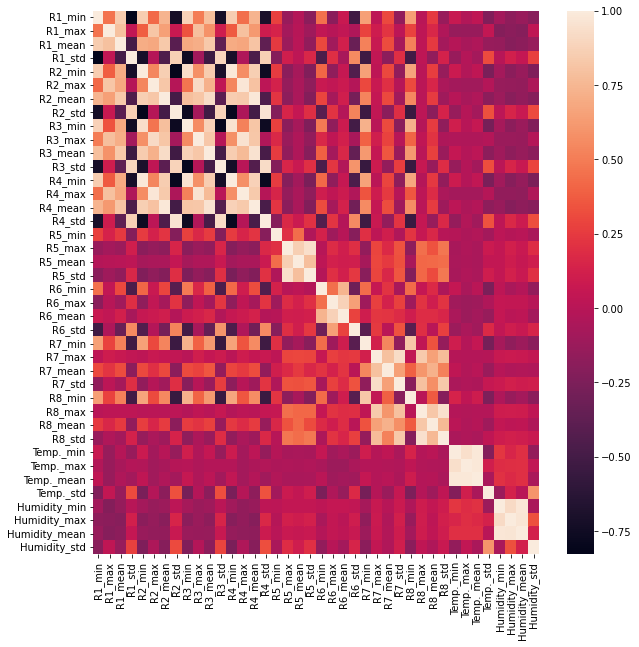

In [ ]:
corr = win_data_sc[win_data_sc.columns[:-3]].corr()
plt.figure(figsize=(10,10))
sn.heatmap(corr)

(REFERENTE A LO DEL PCA DE LUEGO)

Podemos comprobar (con algo de paciencia y una regla) que R2_std (por partir de algun sitio) tiene una correlacion casi 1 con la std de R1-R4 y una anticorrelacion similar con los mínimos

En cambio no tienen tanta correlacion con los máximos, lo que indica que realmente la primera direccion PCA identificada se puede resumir como R2_std (o cualquier otro de los correlacionados)

Por otro lado la 2da PCA recogía los máximos de R2, R3 y R4, que efectivamente tambien estan muy correlacionados y se pueden resumir con cualquier máximo. Por último también se observa que los R7 y R8 están bastante correlacionados (no todos los valores con todos, pero en general son bastante redundantes)

Vemos tambien que R6 y R5 tienen un comportamiento similar con un cuadro de correlaciones altas entre sus distintas medidas (pero R5 y R6 tienen poca correlacion entre ellos); also pasa lo mismo con temperatura y humedad

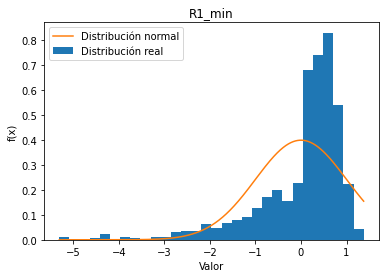

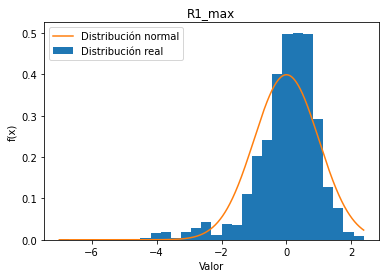

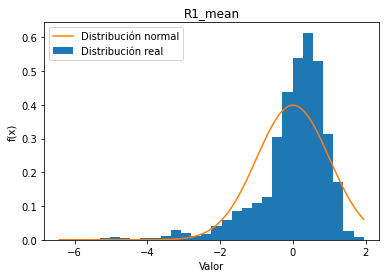

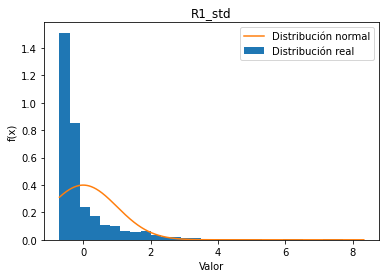

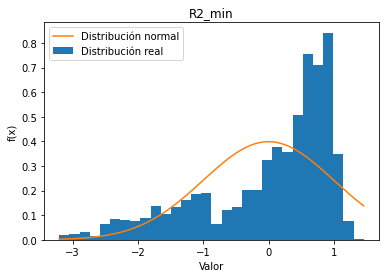

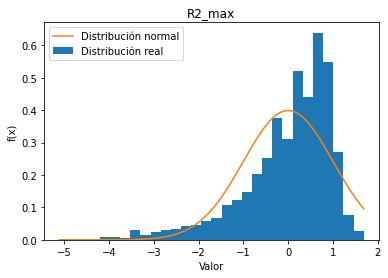

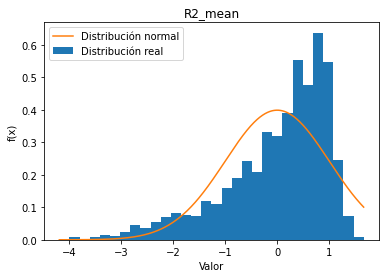

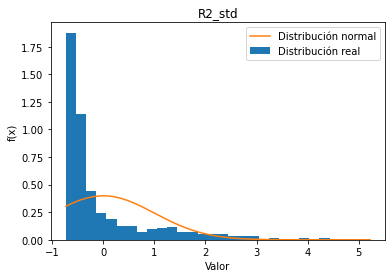

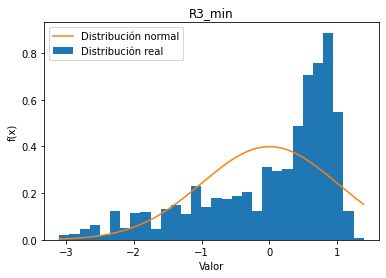

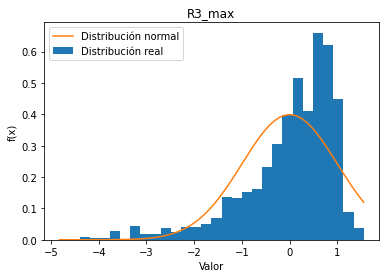

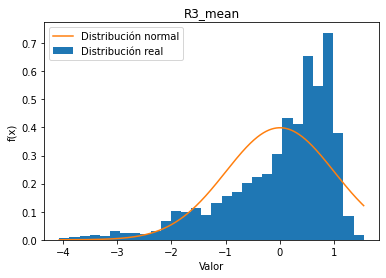

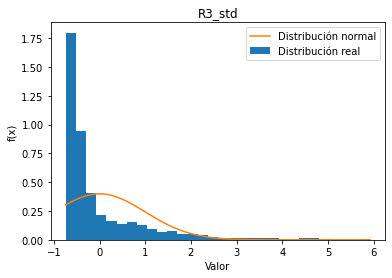

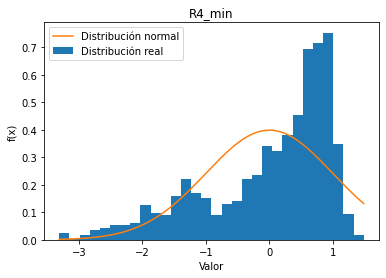

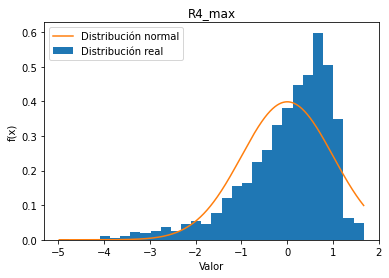

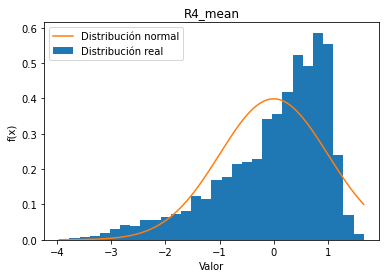

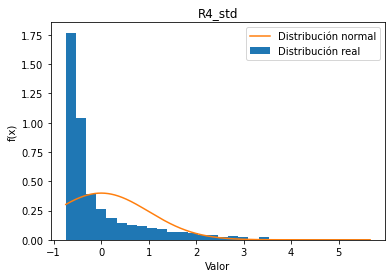

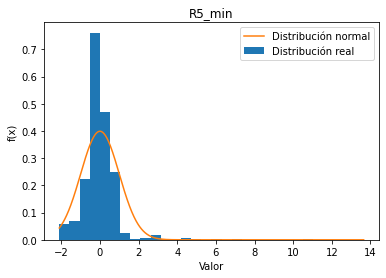

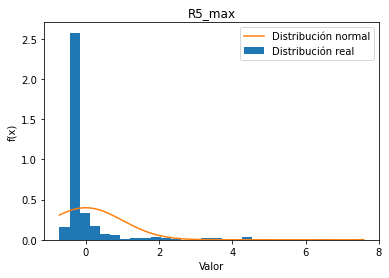

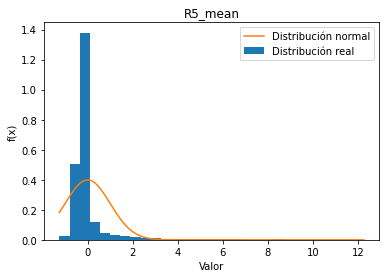

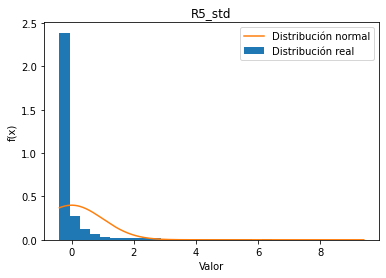

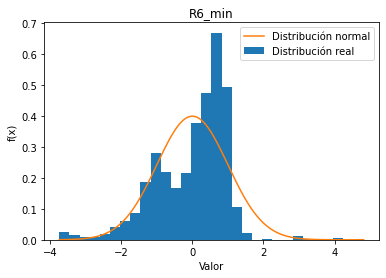

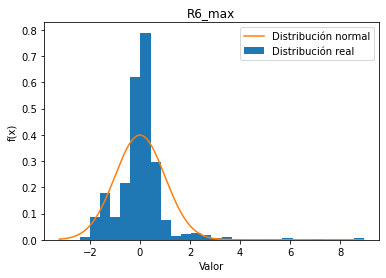

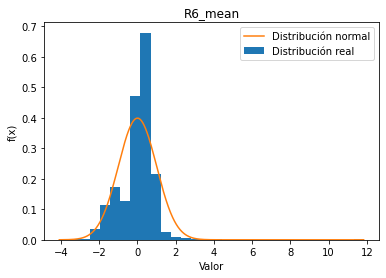

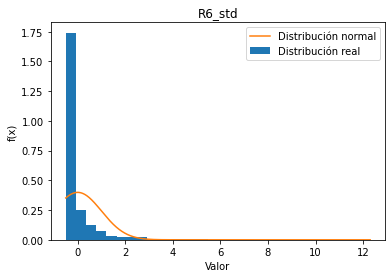

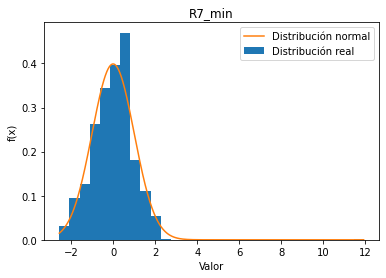

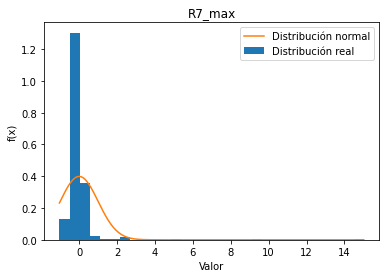

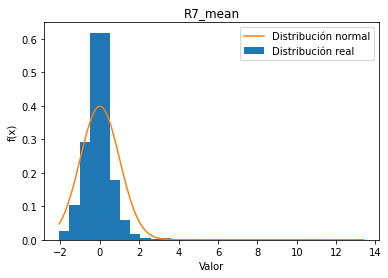

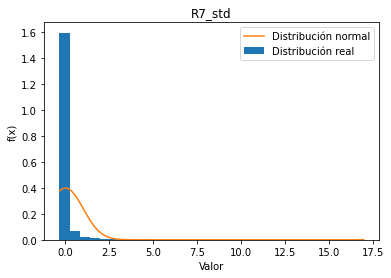

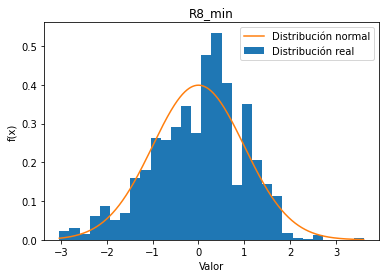

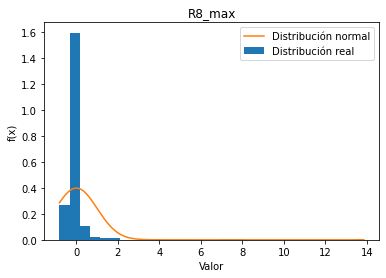

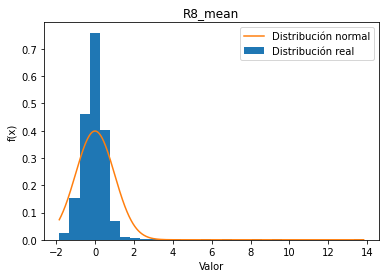

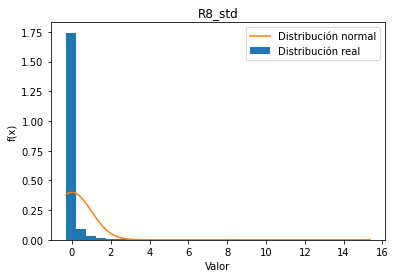

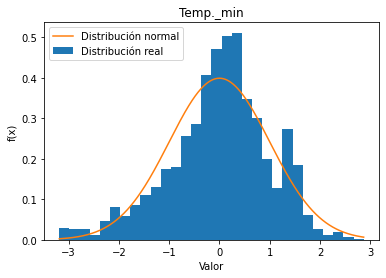

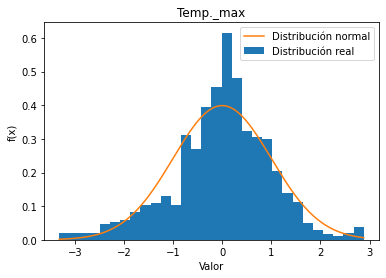

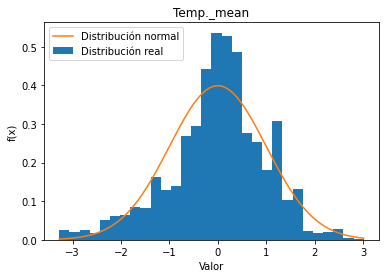

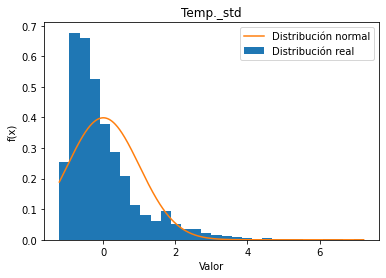

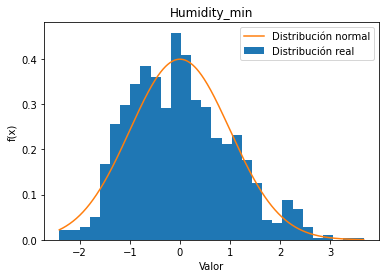

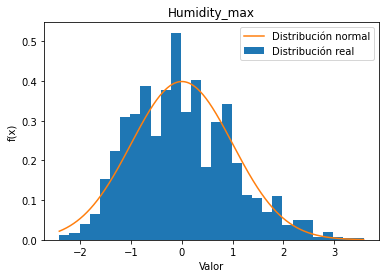

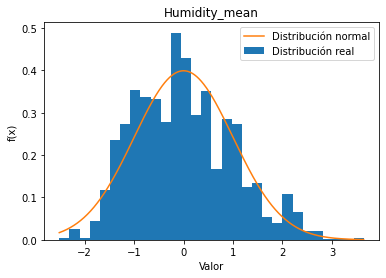

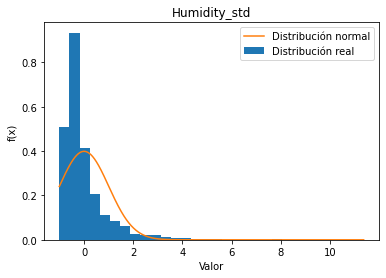

In [ ]:
for column in win_data_sc.columns[:40]:
  plt.hist(win_data_sc.loc[:, column], bins = 30, density=True, label="Distribución real")

  range = np.linspace(min(win_data_sc.loc[:, column]), max(win_data_sc.loc[:, column]), 1000)
  mu, sigma = np.mean(win_data_sc.loc[:, column]), np.var(win_data_sc.loc[:, column])
  plt.plot(range, st.norm.pdf(range, mu, sigma), label="Distribución normal")

  plt.title(column)
  plt.xlabel("Valor")
  plt.ylabel("f(x)")
  plt.legend()
  plt.show()

Los máximos y las medias (y en menor medida los mínimos) más o menos siguen también normales (un poco asimetricos, como antes)

Las varianzas en cambio claramente no son nada normales(que tiene sentido porque una varianza no puede ser normal) pero bueno supongo que confiaremos en que funcione bien anyway.

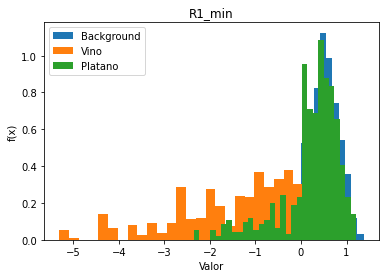

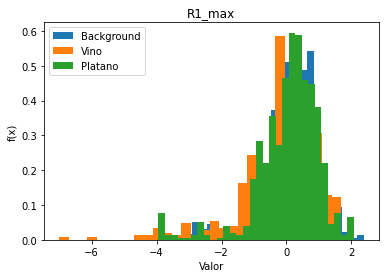

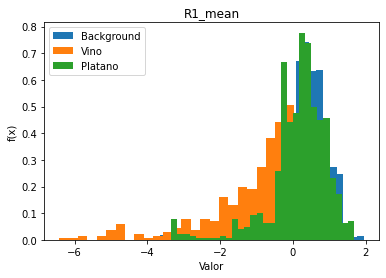

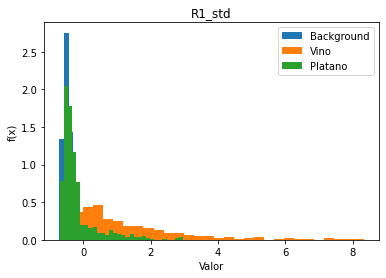

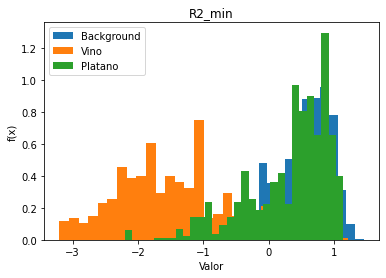

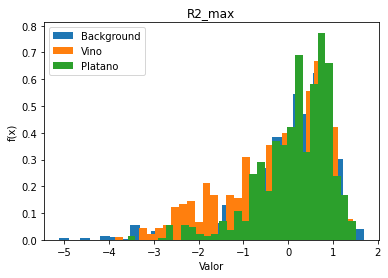

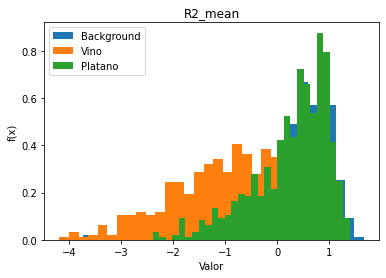

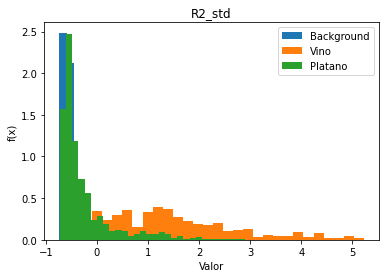

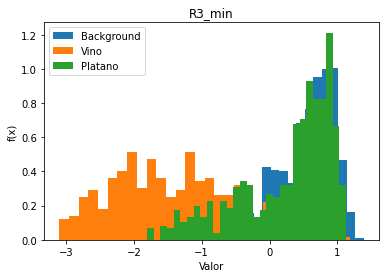

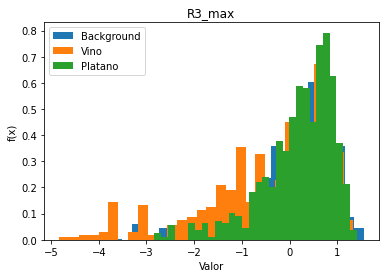

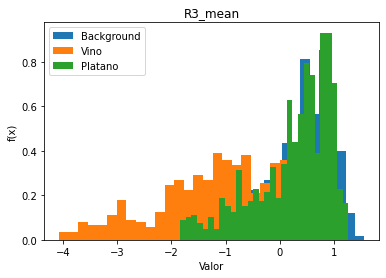

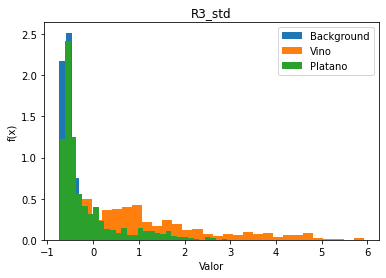

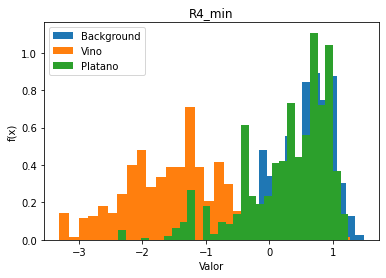

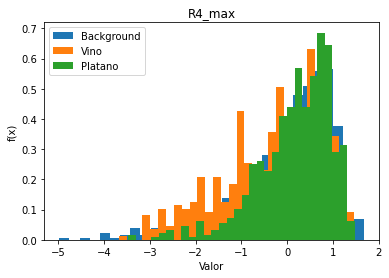

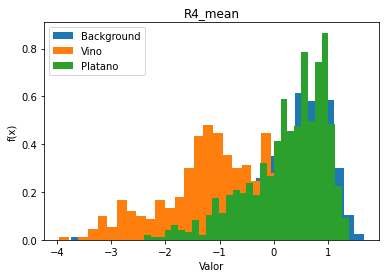

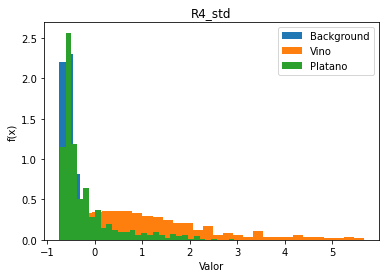

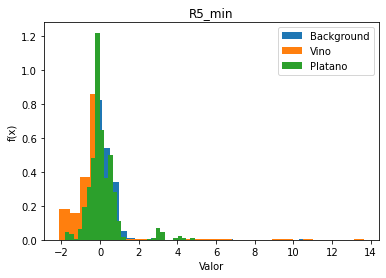

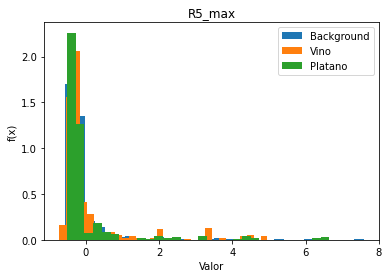

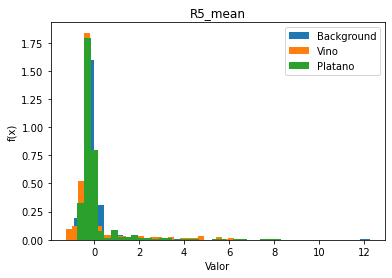

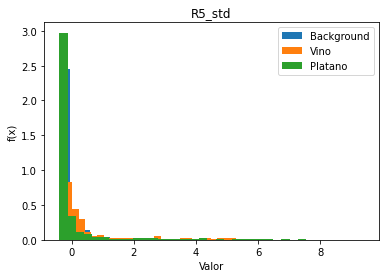

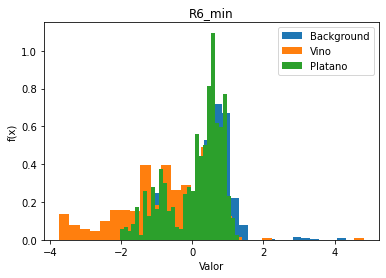

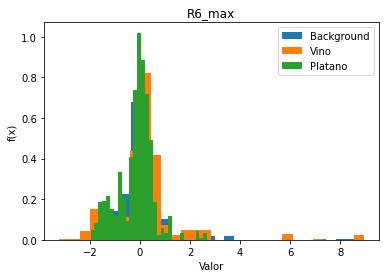

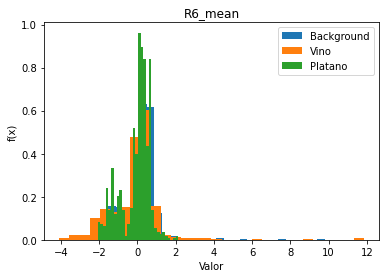

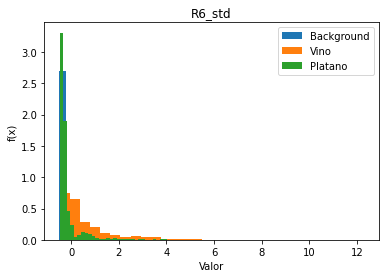

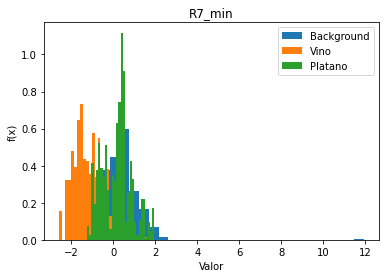

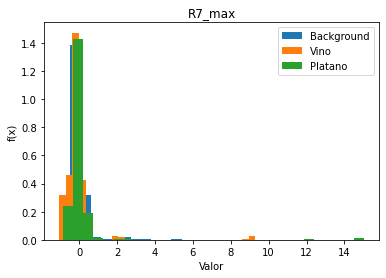

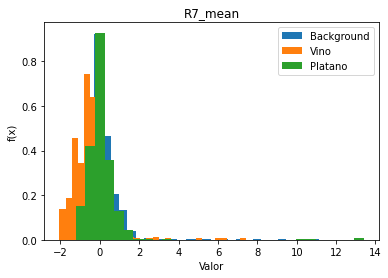

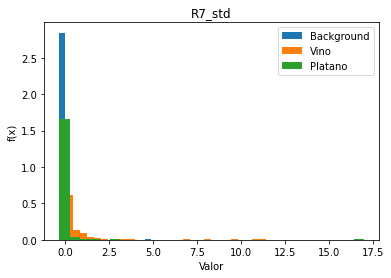

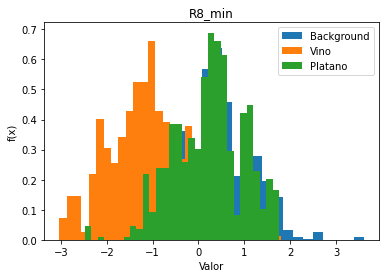

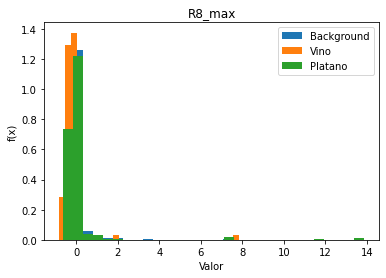

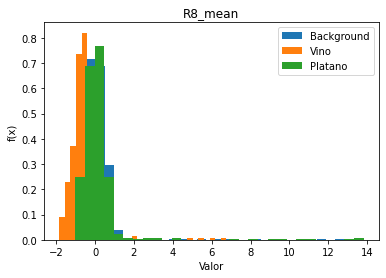

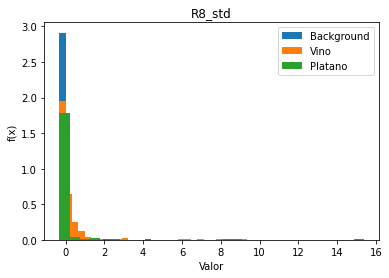

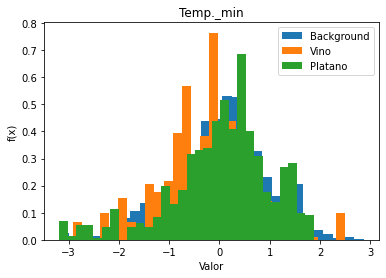

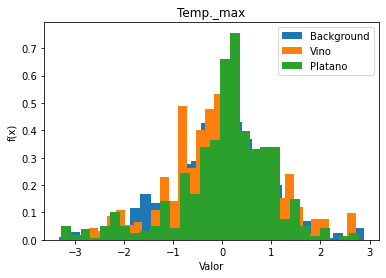

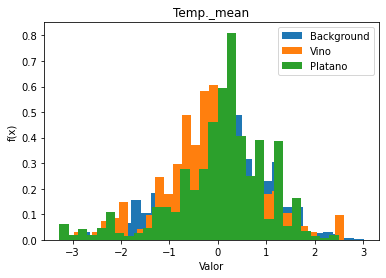

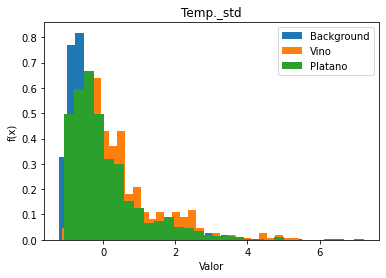

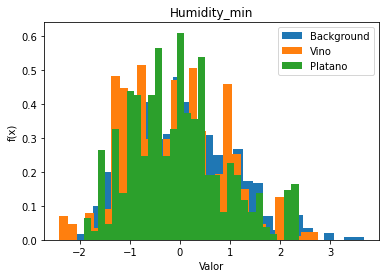

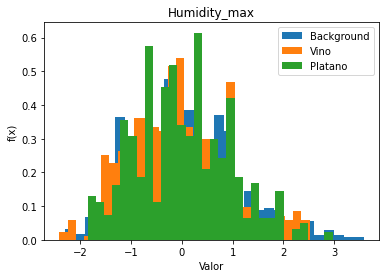

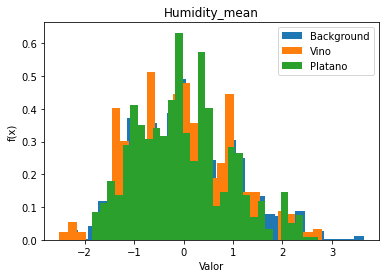

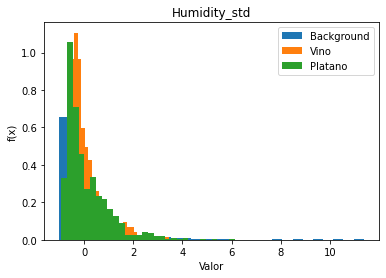

In [ ]:
back = win_data_sc.loc[win_data_sc['class']==0]
wine = win_data_sc.loc[win_data_sc['class']==1]
bana = win_data_sc.loc[win_data_sc['class']==2]

for column in win_data_sc.columns[:40]:
  plt.hist(back.loc[:, column], bins = 30, density=True, label="Background")
  plt.hist(wine.loc[:, column], bins = 30, density=True, label="Vino")
  plt.hist(bana.loc[:, column], bins = 30, density=True, label="Platano")

  plt.title(column)
  plt.xlabel("Valor")
  plt.ylabel("f(x)")
  plt.legend()
  plt.show()

Comprobamos que por separado muchos atributos permiten diferenciar mas o menos bien Vino de Background y Platano, pero de hecho no encontramos ningun atributo que (por separado) permita distinguir bien Platano de Background, lo que confirma la dificultad para separarlos que hemos encontrado luego (de hecho casi llama la atención haber conseguido un error no del todo catastrófico).

## [MMJ] - Reducción de dimensionalidad por PCA y LDA 

### [MMJ] - PCA

In [ ]:
win_pca = PCA()
win_pca = win_pca.fit(win_data_sc[win_data_sc.columns[:-3]])

(-1.0, 10.0)

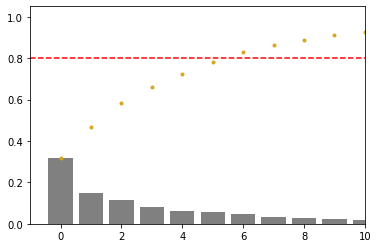

In [ ]:
plt.bar(x=np.arange(40), height=win_pca.explained_variance_ratio_, color="grey")
plt.plot(np.cumsum(win_pca.explained_variance_ratio_), ".", color="goldenrod")
plt.plot([-1,40],[0.8,0.8], "--", color="red")
plt.xlim(-1,10)

Aunque se necesitan bastantes componentes para explicar la variabilidad de estos datos (6 para 80%; ~10 para 90%), aun así tenemos una reducción bastante importante del número de atributos original (40).

Voy a representar los coeficientes de las 6 primeras componentes para comprobar si tienen una interpretación obvia

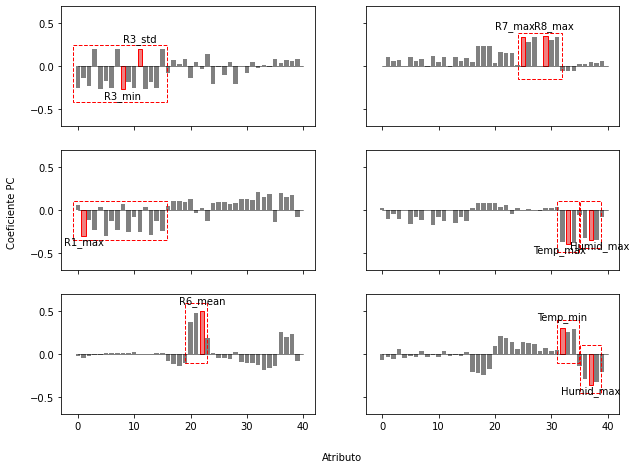

In [ ]:
fig, axs = plt.subplots(3,2,sharex='all', sharey='all', figsize=(10,7.5))
for i in range(6):
  axs[i//2][i%2].bar(x=np.arange(40), height=win_pca.components_[i], color="grey")
  axs[i//2][i%2].plot([0,40], [0,0], color="black", lw=0.5)
  axs[i//2][i%2].set_ylim([-0.7,0.7])

axs[0][0].bar(x=8, height=win_pca.components_[0,8], facecolor="lightcoral", edgecolor="r")
axs[0][0].bar(x=11, height=win_pca.components_[0,11], facecolor="lightcoral", edgecolor="r")
axs[0][0].text(8, win_pca.components_[0,8]-0.1, "R3_min", ha='center')
axs[0][0].text(11, win_pca.components_[0,11]+0.1, "R3_std", ha='center')
axs[0][0].add_patch(mpatches.Rectangle((0-0.9,win_pca.components_[0,11]+0.05),16 + 0.8,-win_pca.components_[0,11] + win_pca.components_[0,8] - 0.2,edgecolor="r",facecolor='none', ls="--"))

axs[0][1].bar(x=25, height=win_pca.components_[1,25], facecolor="lightcoral", edgecolor="r")
axs[0][1].bar(x=29, height=win_pca.components_[1,29], facecolor="lightcoral", edgecolor="r")
axs[0][1].text(25-1.5, win_pca.components_[1,25]+0.1, "R7_max", ha='center')
axs[0][1].text(29+1.5, win_pca.components_[1,29]+0.1, "R8_max", ha='center')
axs[0][1].add_patch(mpatches.Rectangle((25-0.9,win_pca.components_[1,25]+0.05),7 + 0.8,-win_pca.components_[1,25] - 0.2,edgecolor="r",facecolor='none', ls="--"))

axs[1][0].bar(x=1, height=win_pca.components_[2,1], facecolor="lightcoral", edgecolor="r")
axs[1][0].text(1, win_pca.components_[2,1]-0.1, "R1_max", ha='center')
axs[1][0].add_patch(mpatches.Rectangle((0-0.9,win_pca.components_[2,1]-0.05),16 + 0.8,win_pca.components_[2,0] - win_pca.components_[2,1] + 0.1,edgecolor="r",facecolor='none', ls="--"))

axs[1][1].bar(x=33, height=win_pca.components_[3,33], facecolor="lightcoral", edgecolor="r")
axs[1][1].bar(x=37, height=win_pca.components_[3,37], facecolor="lightcoral", edgecolor="r")
axs[1][1].text(33-1.5, win_pca.components_[3,33]-0.1, "Temp_max", ha='center')
axs[1][1].text(37+1.5, win_pca.components_[3,37]-0.1, "Humid_max", ha='center')
axs[1][1].add_patch(mpatches.Rectangle((32-0.9,win_pca.components_[3,33]-0.1),3 + 0.8,-win_pca.components_[3,33] + 0.2,edgecolor="r",facecolor='none', ls="--"))
axs[1][1].add_patch(mpatches.Rectangle((36-0.9,win_pca.components_[3,37]-0.1),3 + 0.8,-win_pca.components_[3,37] + 0.2,edgecolor="r",facecolor='none', ls="--"))

axs[2][0].bar(x=22, height=win_pca.components_[4,22], facecolor="lightcoral", edgecolor="r")
axs[2][0].text(22, win_pca.components_[4,22]+0.1, "R6_mean", ha='center')
axs[2][0].add_patch(mpatches.Rectangle((20-0.9,win_pca.components_[4,22]+0.1),3 + 0.8,-win_pca.components_[4,22] - 0.2,edgecolor="r",facecolor='none', ls="--"))

axs[2][1].bar(x=32, height=win_pca.components_[5,32], facecolor="lightcoral", edgecolor="r")
axs[2][1].bar(x=37, height=win_pca.components_[5,37], facecolor="lightcoral", edgecolor="r")
axs[2][1].text(32, win_pca.components_[5,32]+0.1, "Temp_min", ha='center')
axs[2][1].text(37, win_pca.components_[5,37]-0.1, "Humid_max", ha='center')
axs[2][1].add_patch(mpatches.Rectangle((32-0.9,win_pca.components_[5,32]+0.1),3 + 0.8,-win_pca.components_[5,32] - 0.2,edgecolor="r",facecolor='none', ls="--"))
axs[2][1].add_patch(mpatches.Rectangle((36-0.9,win_pca.components_[5,37]-0.1),3 + 0.8,-win_pca.components_[5,37] + 0.2,edgecolor="r",facecolor='none', ls="--"))

  #for j in np.argsort(np.abs(win_pca.components_[i]))[-1:-4:-1]:
    #axs[i//2][i%2].text(j, win_pca.components_[i,j], win_data_sc.columns[j])
fig.text(0.515, 0.04, 'Atributo', ha='center')
fig.text(0.05, 0.5, 'Coeficiente PC', va='center', rotation='vertical')
plt.savefig("pca_coefs.png", dpi=320)

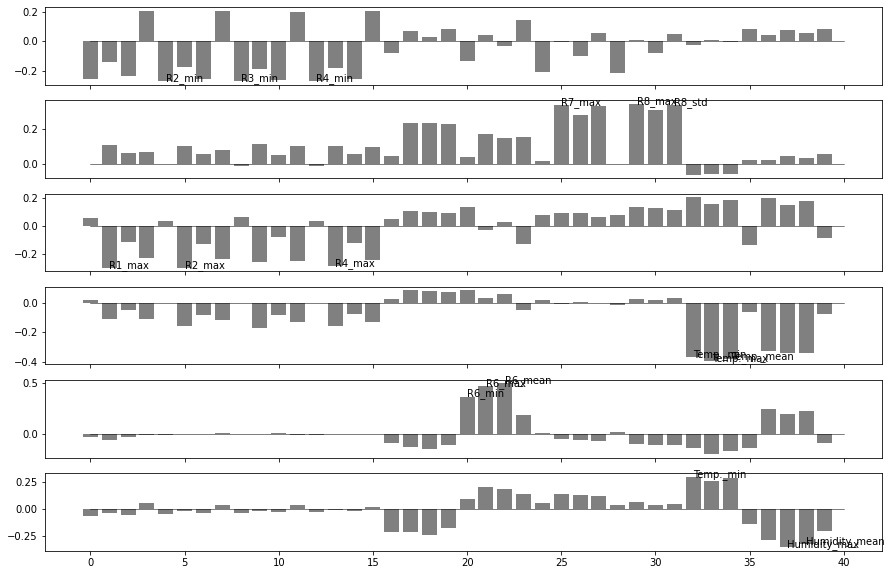

In [ ]:
fig, axs = plt.subplots(6z,1,sharex=True, figsize=(15,10))
for i in range(6):
  axs[i].bar(x=np.arange(40), height=win_pca.components_[i], color="grey")
  axs[i].plot([0,40], [0,0], color="black", lw=0.5)
  for j in np.argsort(np.abs(win_pca.components_[i]))[-1:-4:-1]:
    axs[i].text(j, win_pca.components_[i,j], win_data_sc.columns[j])

Aunque resulta bastante complicado encontrar una interpretación, propongo lo siguiente:

1. PC1: stds de varios sensores menos el mínimo, podemos intentar relfejar como R3_std - R3_min

2. PC2: R7_max + R8_max

3. PC3: -R1_max

4. PC4: -Temp_max - Humid_max

5. PC5: R6_mean

6. PC6: Temp_min - Humid_max

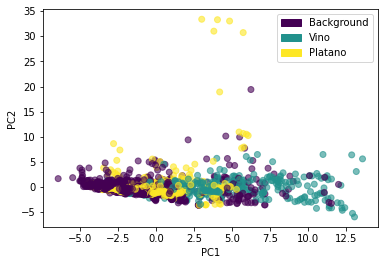

In [ ]:
pca_win_data_train = win_pca.transform(win_data_train_sc[win_data_train_sc.columns[:-3]])
pca_win_data_test = win_pca.transform(win_data_test_sc[win_data_test_sc.columns[:-3]])

plt.figure()
cmap = plt.get_cmap("viridis")
plt.scatter(pca_win_data_train[:,0], pca_win_data_train[:,1], c=win_data_train['class'], alpha=0.6, cmap=cmap)
plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['Background', "Vino", "Platano"])
#plt.title("PCA 2D // Train")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("pca2D_sep.png", dpi=320)

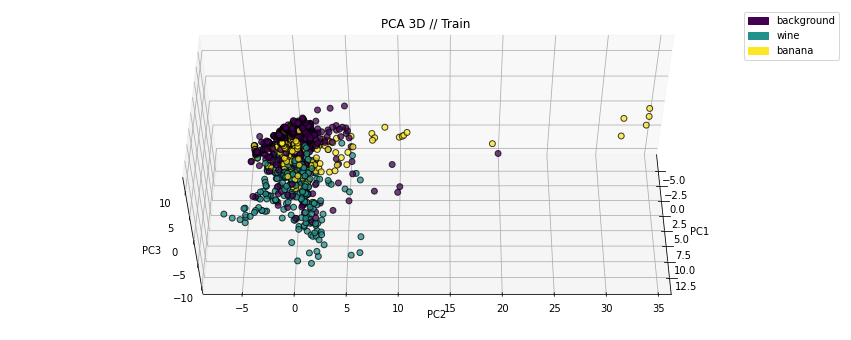

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = []
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(pca_win_data_train[:,0], pca_win_data_train[:,1], pca_win_data_train[:,2], c=win_data_train['class'], edgecolors='k', alpha=0.75,s=35, cmap=cmap)
ax.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['background', "wine", "banana"])
ax.set_title("PCA 3D // Train")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

def animation(i):
  ax.view_init(50,i)
  return ax

ani = FuncAnimation(fig, animation, frames=360, 
                    interval=50, repeat=False)
ani.save("pca_3d.mp4",dpi=100)
fig.show()

In [ ]:
[ (i,col) for i, col in enumerate(win_data.columns)]

[(0, 'R1_min'),
 (1, 'R1_max'),
 (2, 'R1_mean'),
 (3, 'R1_std'),
 (4, 'R2_min'),
 (5, 'R2_max'),
 (6, 'R2_mean'),
 (7, 'R2_std'),
 (8, 'R3_min'),
 (9, 'R3_max'),
 (10, 'R3_mean'),
 (11, 'R3_std'),
 (12, 'R4_min'),
 (13, 'R4_max'),
 (14, 'R4_mean'),
 (15, 'R4_std'),
 (16, 'R5_min'),
 (17, 'R5_max'),
 (18, 'R5_mean'),
 (19, 'R5_std'),
 (20, 'R6_min'),
 (21, 'R6_max'),
 (22, 'R6_mean'),
 (23, 'R6_std'),
 (24, 'R7_min'),
 (25, 'R7_max'),
 (26, 'R7_mean'),
 (27, 'R7_std'),
 (28, 'R8_min'),
 (29, 'R8_max'),
 (30, 'R8_mean'),
 (31, 'R8_std'),
 (32, 'Temp._min'),
 (33, 'Temp._max'),
 (34, 'Temp._mean'),
 (35, 'Temp._std'),
 (36, 'Humidity_min'),
 (37, 'Humidity_max'),
 (38, 'Humidity_mean'),
 (39, 'Humidity_std'),
 (40, 'class'),
 (41, 'id'),
 (42, 'start')]

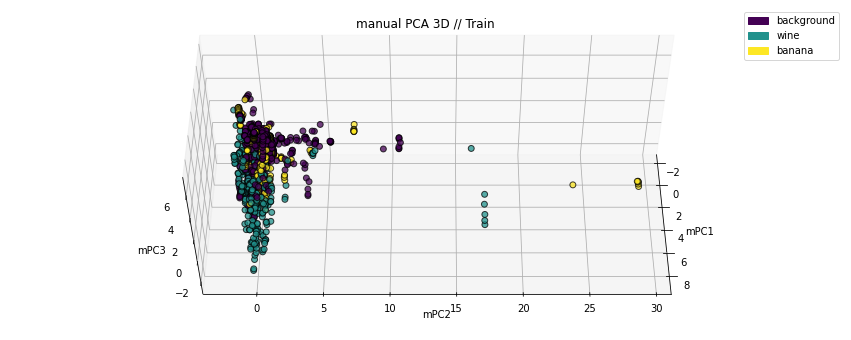

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = []
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(win_data_sc['R3_std'] - win_data_sc['R3_min'], win_data_sc['R7_max'] + win_data_sc['R8_max'], -1*win_data_sc['R1_max'], c=win_data_sc['class'], edgecolors='k', alpha=0.75,s=35, cmap=cmap)
ax.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['background', "wine", "banana"])
ax.set_title("manual PCA 3D // Train")
ax.set_xlabel("mPC1")
ax.set_ylabel("mPC2")
ax.set_zlabel("mPC3")

def animation(i):
  ax.view_init(50,i)
  return ax

ani = FuncAnimation(fig, animation, frames=360, 
                    interval=50, repeat=False)
ani.save("semi_pca_3d.mp4",dpi=100)
fig.show()

In [ ]:
mpca_win_data_train = np.array([win_data_train_sc['R3_std'] - win_data_train_sc['R3_min'], 
                                win_data_train_sc['R7_max'] + win_data_train_sc['R8_max'], 
                                -1*win_data_train_sc['R1_max'],
                                -1*win_data_train_sc['Temp._max'] - win_data_train_sc['Humidity_max'],
                                win_data_train_sc['R6_mean'],
                                win_data_train_sc['Temp._min'] - win_data_train_sc['Humidity_max']]).T
mpca_win_data_test = np.array([win_data_test_sc['R3_std'] - win_data_test_sc['R3_min'], 
                                win_data_test_sc['R7_max'] + win_data_test_sc['R8_max'], 
                                -1*win_data_test_sc['R1_max'],
                                -1*win_data_test_sc['Temp._max'] - win_data_test_sc['Humidity_max'],
                                win_data_test_sc['R6_mean'],
                                win_data_test_sc['Temp._min'] - win_data_test_sc['Humidity_max']]).T

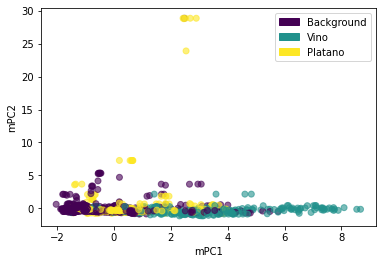

In [ ]:
plt.figure()
cmap = plt.get_cmap("viridis")
plt.scatter(mpca_win_data_train[:,0], mpca_win_data_train[:,1], c=win_data_train['class'], alpha=0.6, cmap=cmap)
plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['Background', "Vino", "Platano"])
#plt.title("PCA 2D // Train")
plt.xlabel("mPC1")
plt.ylabel("mPC2")
plt.savefig("mpca2D_sep.png", dpi=320)

### PCA Outlier-Free

In [ ]:
of_win_pca = PCA()
of_win_pca = of_win_pca.fit(of_win_data_sc[of_win_data_sc.columns[:-3]])

(-1.0, 10.0)

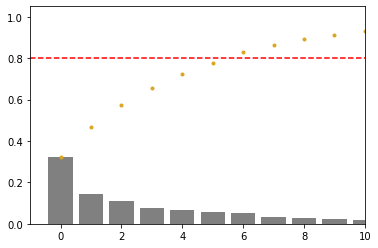

In [ ]:
plt.bar(x=np.arange(40), height=of_win_pca.explained_variance_ratio_, color="grey")
plt.plot(np.cumsum(of_win_pca.explained_variance_ratio_), ".", color="goldenrod")
plt.plot([-1,40],[0.8,0.8], "--", color="red")
plt.xlim(-1,10)

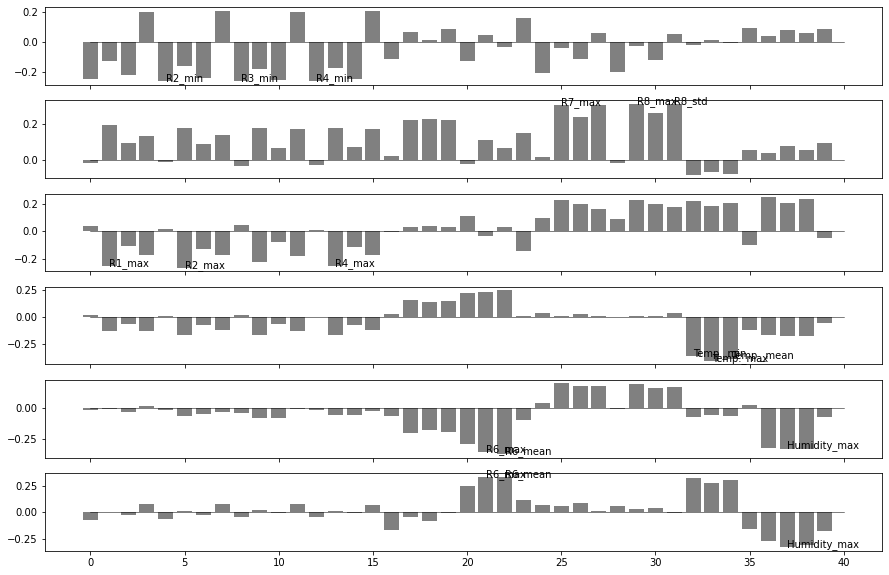

In [ ]:
fig, axs = plt.subplots(6,1,sharex=True, figsize=(15,10))
for i in np.arange(6):
  axs[i].bar(x=np.arange(40), height=of_win_pca.components_[i], color="grey")
  axs[i].plot([0,40], [0,0], color="black", lw=0.5)
  for j in np.argsort(np.abs(of_win_pca.components_[i]))[-1:-4:-1]:
    axs[i].text(j, of_win_pca.components_[i,j], of_win_data_sc.columns[j])

Bastante parecidos al normal

Text(0, 0.5, 'PC2')

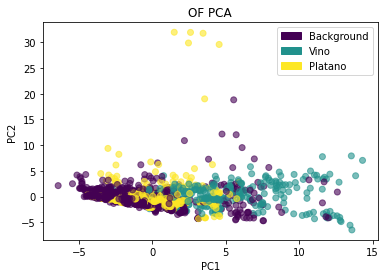

In [ ]:
of_pca_win_data_train = of_win_pca.transform(of_win_data_train_sc[of_win_data_train_sc.columns[:-3]])
of_pca_win_data_test = of_win_pca.transform(of_win_data_test_sc[of_win_data_test_sc.columns[:-3]])

plt.figure()
cmap = plt.get_cmap("viridis")
plt.scatter(of_pca_win_data_train[:,0], of_pca_win_data_train[:,1], c=of_win_data_train['class'], alpha=0.6, cmap=cmap)
plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['Background', "Vino", "Platano"])
plt.title("OF PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")

Tiene pinta de estar un pelin mejor separado, pero vamos tampoco mucha cosa (?)

In [ ]:
of_mpca_win_data_train = np.array([of_win_data_train_sc['R3_std'] - of_win_data_train_sc['R3_min'], 
                                of_win_data_train_sc['R7_max'] + of_win_data_train_sc['R8_max'], 
                                -1*of_win_data_train_sc['R1_max'],
                                -1*of_win_data_train_sc['Temp._max'] - of_win_data_train_sc['Humidity_max'],
                                of_win_data_train_sc['R6_mean'],
                                of_win_data_train_sc['Temp._min'] - of_win_data_train_sc['Humidity_max']]).T
of_mpca_win_data_test = np.array([of_win_data_test_sc['R3_std'] - of_win_data_test_sc['R3_min'], 
                                of_win_data_test_sc['R7_max'] + of_win_data_test_sc['R8_max'], 
                                -1*of_win_data_test_sc['R1_max'],
                                -1*of_win_data_test_sc['Temp._max'] - of_win_data_test_sc['Humidity_max'],
                                of_win_data_test_sc['R6_mean'],
                                of_win_data_test_sc['Temp._min'] - of_win_data_test_sc['Humidity_max']]).T

#### [AAF] - Datasets puros (solo estímulo)

In [ ]:
win_est_pca = PCA()
win_est_pca = win_est_pca.fit(win_est_sc[win_est_train_sc.columns[:-3]])

In [ ]:
plt.bar(x=np.arange(40), height=win_est_pca.explained_variance_ratio_, color="grey")
plt.plot(np.cumsum(win_est_pca.explained_variance_ratio_), ".", color="goldenrod")
plt.plot([-1,40],[0.8,0.8], "--", color="red")
plt.xlim(-1,10)

Representacion de las 6 primeras componentes

In [ ]:
fig, axs = plt.subplots(6,1,sharex=True, figsize=(15,10))
for i in range(6):
  axs[i].bar(x=np.arange(40), height=win_est_pca.components_[i], color="grey")
  axs[i].plot([0,40], [0,0], color="black", lw=0.5)
  for j in np.argsort(np.abs(win_est_pca.components_[i]))[-1:-4:-1]:
    axs[i].text(j, win_est_pca.components_[i,j], win_est_train_sc.columns[j])

La descomposición en mPCA es virtualmente la misma:

In [ ]:
mpca_win_est_train = np.array([win_est_train_sc['R3_std'] - win_est_train_sc['R3_min'], 
                                win_est_train_sc['R7_max'] + win_est_train_sc['R8_max'], 
                                -1*win_est_train_sc['R1_max'],
                                -1*win_est_train_sc['Temp._mean'] - win_est_train_sc['Humidity_max'],
                                win_est_train_sc['R5_std'],
                                win_est_train_sc['R6_max']]).T
mpca_win_est_test = np.array([win_est_test_sc['R3_std'] - win_est_test_sc['R3_min'], 
                                win_est_test_sc['R7_max'] + win_est_test_sc['R8_max'], 
                                -1*win_est_test_sc['R1_max'],
                                -1*win_est_test_sc['Temp._mean'] - win_est_test_sc['Humidity_max'],
                                win_est_test_sc['R5_std'],
                                win_est_test_sc['R6_max']]).T

Representamos las 2 primeras componentes de PCA y mPCA

In [ ]:
pca_win_est_train = win_est_pca.transform(win_est_train_sc[win_est_train_sc.columns[:-3]])
pca_win_est_test = win_est_pca.transform(win_est_test_sc[win_est_test_sc.columns[:-3]])

plt.figure()
cmap = plt.get_cmap("viridis")
plt.scatter(pca_win_est_train[:,0], pca_win_est_train[:,1], c=win_est_train_sc['class'], alpha=0.6, cmap=cmap)
plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['background', "wine", "banana"])
plt.title("PCA 2D // Train")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [ ]:
plt.figure()
cmap = plt.get_cmap("viridis")
plt.scatter(mpca_win_est_train[:,0], mpca_win_est_train[:,1], c=win_est_train_sc['class'], alpha=0.6, cmap=cmap)
plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['background', "wine", "banana"])
plt.title("mPCA 2D // Train")
plt.xlabel("PC1")
plt.ylabel("PC2")

Guardamos los dataframes

In [ ]:
pca_win_est_train = pd.DataFrame(np.array(pca_win_est_train)[:,:6], columns=["PC"+str(k) for k in range(1,7)])
pca_win_est_test = pd.DataFrame(np.array(pca_win_est_test)[:,:6], columns=["PC"+str(k) for k in range(1,7)])
mpca_win_est_train = pd.DataFrame(mpca_win_est_train, columns=["mPC"+str(k) for k in range(1,7)])
mpca_win_est_test = pd.DataFrame(mpca_win_est_test, columns=["mPC"+str(k) for k in range(1,7)])

for col in list(win_data_sc.columns[-3:]):
  pca_win_est_train.insert(loc=len(pca_win_est_train.columns),
                           column=col,
                           value=win_est_train_sc[col])
  pca_win_est_test.insert(loc=len(pca_win_est_test.columns),
                           column=col,
                           value=win_est_test_sc[col])
  mpca_win_est_train.insert(loc=len(mpca_win_est_train.columns),
                           column=col,
                           value=win_data_train[col])
  mpca_win_est_test.insert(loc=len(mpca_win_est_test.columns),
                           column=col,
                           value=win_data_test[col])
  
  if col == "class" or col=="id":
    pca_win_est_train[col] = pca_win_est_train[col].astype(int)
    pca_win_est_test[col] = pca_win_est_test[col].astype(int)
    mpca_win_est_train[col] = mpca_win_est_train[col].astype(int)
    mpca_win_est_test[col] = mpca_win_est_test[col].astype(int)

pca_win_est_train.to_csv("pca_win_est_train.csv")
pca_win_est_test.to_csv("pca_win_est_test.csv")
mpca_win_est_train.to_csv("mpca_win_est_train.csv")
mpca_win_est_test.to_csv("mpca_win_est_test.csv")

In [ ]:
of_pca_win_data_train = pd.DataFrame(of_pca_win_data_train[:,:6], columns=["PC"+str(k) for k in np.arange(1,7)])
of_pca_win_data_test = pd.DataFrame(of_pca_win_data_test[:,:6], columns=["PC"+str(k) for k in np.arange(1,7)])
of_mpca_win_data_train = pd.DataFrame(of_mpca_win_data_train, columns=["mPC"+str(k) for k in np.arange(1,7)])
of_mpca_win_data_test = pd.DataFrame(of_mpca_win_data_test, columns=["mPC"+str(k) for k in np.arange(1,7)])

for col in list(of_win_data_sc.columns[-3:]):
  of_pca_win_data_train.insert(loc=len(of_pca_win_data_train.columns),
                           column=col,
                           value=of_win_data_train_sc[col])
  of_pca_win_data_test.insert(loc=len(of_pca_win_data_test.columns),
                           column=col,
                           value=of_win_data_test_sc[col])
  of_mpca_win_data_train.insert(loc=len(of_mpca_win_data_train.columns),
                           column=col,
                           value=of_win_data_train[col])
  of_mpca_win_data_test.insert(loc=len(of_mpca_win_data_test.columns),
                           column=col,
                           value=of_win_data_test[col])
  
  if col == "class" or col=="id":
    of_pca_win_data_train[col] = of_pca_win_data_train[col].astype(int)
    of_pca_win_data_test[col] = of_pca_win_data_test[col].astype(int)
    of_mpca_win_data_train[col] = of_mpca_win_data_train[col].astype(int)
    of_mpca_win_data_test[col] = of_mpca_win_data_test[col].astype(int)

of_pca_win_data_train.to_csv("of_pca_win_data_train.csv")
of_pca_win_data_test.to_csv("of_pca_win_data_test.csv")
of_mpca_win_data_train.to_csv("of_mpca_win_data_train.csv")
of_mpca_win_data_test.to_csv("of_mpca_win_data_test.csv")

### [MMJ] - LDA

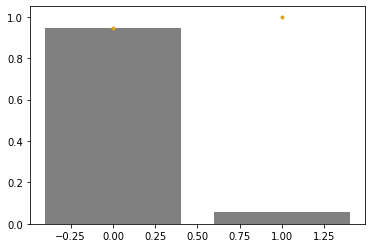

In [ ]:
plt.bar(x=np.arange(2), height=win_lda.explained_variance_ratio_, color="grey")
plt.plot(np.cumsum(win_lda.explained_variance_ratio_), ".", color="goldenrod")

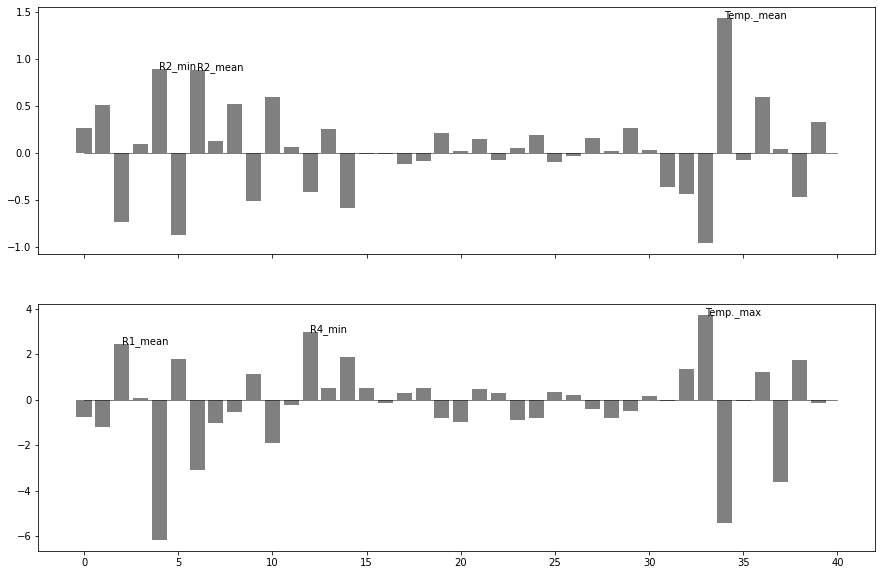

In [ ]:
fig, axs = plt.subplots(2,1,sharex=True, figsize=(15,10))
for i in range(2):
  axs[i].bar(x=np.arange(40), height=win_lda.coef_[i], color="grey")
  axs[i].plot([0,40], [0,0], color="black", lw=0.5)
  for j in np.argsort(win_lda.coef_[i])[-1:-4:-1]:
    axs[i].text(j, win_lda.coef_[i,j], win_data_sc.columns[j])

Este LDA tal vez si que podría tener una interpretación más sparse con 2 o 3 sensores, no sé si hacerlo.

### LDA Outlier-Free

In [ ]:
of_win_lda = LinearDiscriminantAnalysis()
of_win_lda.fit(of_win_data_train_sc[of_win_data_train_sc.columns[:40]], of_win_data_train['class'])

of_lda_win_data_train = of_win_lda.transform(of_win_data_train_sc[of_win_data_train_sc.columns[:40]])
of_lda_win_data_test = of_win_lda.transform(of_win_data_test_sc[of_win_data_test_sc.columns[:40]])

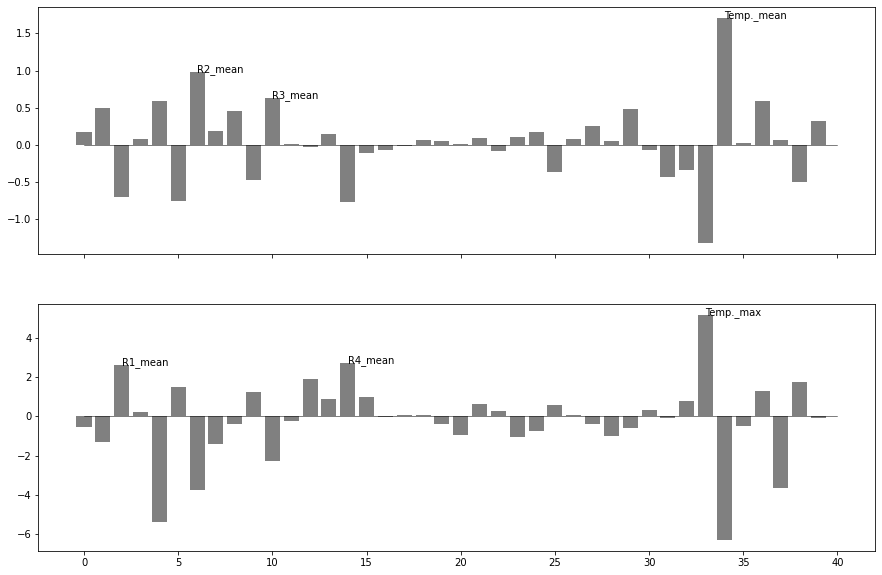

In [ ]:
fig, axs = plt.subplots(2,1,sharex=True, figsize=(15,10))
for i in np.arange(2):
  axs[i].bar(x=np.arange(40), height=of_win_lda.coef_[i], color="grey")
  axs[i].plot([0,40], [0,0], color="black", lw=0.5)
  for j in np.argsort(of_win_lda.coef_[i])[-1:-4:-1]:
    axs[i].text(j, of_win_lda.coef_[i,j], of_win_data_sc.columns[j])

In [ ]:
of_lda_win_data_train = pd.DataFrame(of_lda_win_data_train, columns=["LD1","LD2"])
of_lda_win_data_test = pd.DataFrame(of_lda_win_data_test, columns=["LD1","LD2"])

for col in list(of_win_data_train.columns[-3:]):
  of_lda_win_data_train.insert(loc=len(of_lda_win_data_train.columns),
                           column=col,
                           value=of_win_data_train[col])
  of_lda_win_data_test.insert(loc=len(of_lda_win_data_test.columns),
                           column=col,
                           value=of_win_data_test[col])
  
  if col == "class" or col=="id":
    of_lda_win_data_train[col] = of_lda_win_data_train[col].astype(int)
    of_lda_win_data_test[col] = of_lda_win_data_test[col].astype(int)

of_lda_win_data_train.to_csv("of_lda_win_data_train.csv")
of_lda_win_data_test.to_csv("of_lda_win_data_test.csv")

### Paso de los PCA / mPCA a DataFrame y tal

In [ ]:
pca_win_data_train = pd.DataFrame(pca_win_data_train[:,:6], columns=["PC"+str(k) for k in range(1,7)])
pca_win_data_test = pd.DataFrame(pca_win_data_test[:,:6], columns=["PC"+str(k) for k in range(1,7)])
mpca_win_data_train = pd.DataFrame(mpca_win_data_train, columns=["mPC"+str(k) for k in range(1,7)])
mpca_win_data_test = pd.DataFrame(mpca_win_data_test, columns=["mPC"+str(k) for k in range(1,7)])

for col in list(win_data_sc.columns[-3:]):
  pca_win_data_train.insert(loc=len(pca_win_data_train.columns),
                           column=col,
                           value=win_data_train[col])
  pca_win_data_test.insert(loc=len(pca_win_data_test.columns),
                           column=col,
                           value=win_data_test[col])
  mpca_win_data_train.insert(loc=len(mpca_win_data_train.columns),
                           column=col,
                           value=win_data_train[col])
  mpca_win_data_test.insert(loc=len(mpca_win_data_test.columns),
                           column=col,
                           value=win_data_test[col])
  
  if col == "class" or col=="id":
    pca_win_data_train[col] = pca_win_data_train[col].astype(int)
    pca_win_data_test[col] = pca_win_data_test[col].astype(int)
    mpca_win_data_train[col] = mpca_win_data_train[col].astype(int)
    mpca_win_data_test[col] = mpca_win_data_test[col].astype(int)

pca_win_data_train.to_csv("pca_win_data_train.csv")
pca_win_data_test.to_csv("pca_win_data_test.csv")
mpca_win_data_train.to_csv("mpca_win_data_train.csv")
mpca_win_data_test.to_csv("mpca_win_data_test.csv")

#### [AAF] - Datasets puros (solo estímulo)

Representamos el espacio LDA 

In [ ]:
win_est_lda = LinearDiscriminantAnalysis(priors=[1/3,1/3,1/3])
win_est_lda.fit(win_est_train_sc, win_est_train['class'])

lda_win_est_train = win_est_lda.transform(win_est_train_sc)

cmap = plt.get_cmap("viridis")
plt.scatter(lda_win_est_train[:,0], lda_win_est_train[:,1], c=win_est_train['class'], alpha=0.6, cmap=cmap)
plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['background', "wine", "banana"])
plt.title("LDA solo el estímulo ~ Train // Training")
plt.xlabel("LD1")
plt.ylabel("LD2")

Test en el espacio LDA...

In [ ]:
lda_win_est_test = win_est_lda.transform(win_est_test_sc)

cmap = plt.get_cmap("viridis")
plt.scatter(lda_win_est_test[:,0], lda_win_est_test[:,1], c=win_est_test['class'], alpha=0.6, cmap=cmap)
plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['background', "wine", "banana"])
plt.title("LDA solo el estímulo ~ Test")
plt.xlabel("LD1")
plt.ylabel("LD2")

Guardamos los datasets

In [ ]:
win_est_train_sc = pd.DataFrame(win_est_train_sc, columns=win_est_train.columns[:-3])
win_est_test_sc = pd.DataFrame(win_est_test_sc, columns=win_est_test.columns[:-3])
lda_win_est_train = pd.DataFrame(lda_win_est_train, columns=["LD1","LD2"])
lda_win_est_test = pd.DataFrame(lda_win_est_test, columns=["LD1","LD2"])

for col in list(win_est_train.columns[-3:]):
  win_est_train_sc.insert(loc=len(win_est_train_sc.columns),
                           column=col,
                           value=win_est_train[col])
  win_est_test_sc.insert(loc=len(win_est_test_sc.columns),
                           column=col,
                           value=win_est_test[col])
  lda_win_est_train.insert(loc=len(lda_win_est_train.columns),
                           column=col,
                           value=win_est_train[col])
  lda_win_est_test.insert(loc=len(lda_win_est_test.columns),
                           column=col,
                           value=win_est_test[col])
  
  if col == "class" or col=="id":
    win_est_train_sc[col] = win_est_train_sc[col].astype(int)
    win_est_test_sc[col] = win_est_test_sc[col].astype(int)
    lda_win_est_train[col] = lda_win_est_train[col].astype(int)
    lda_win_est_test[col] = lda_win_est_test[col].astype(int)

win_est_train_sc.to_csv("win_est_train_sc.csv")
win_est_test_sc.to_csv("win_est_test_sc.csv")
lda_win_est_train.to_csv("lda_win_est_train.csv")
lda_win_est_test.to_csv("lda_win_est_test.csv")

## [AAF] - Regresión logística

In [ ]:
import sklearn.linear_model as lm

In [ ]:
ts_meta_train = pd.read_csv("ts_meta_train.csv", index_col=0)
ts_train = pd.read_csv("ts_train.csv", index_col=0)

win_data_train_sc = pd.read_csv("win_data_train_sc.csv", index_col=0)
win_data_train = pd.read_csv("win_data_train.csv",index_col=0)
win_data_test_sc = pd.read_csv("win_data_test_sc.csv", index_col=0)
win_data_test = pd.read_csv("win_data_test.csv",index_col=0)

win_est_train_sc = pd.read_csv("win_est_train_sc.csv",index_col=0)
win_est_test_sc = pd.read_csv("win_est_test_sc.csv",index_col=0)

lda_win_est_train = pd.read_csv("lda_win_est_train.csv",index_col=0)
lda_win_est_test = pd.read_csv("lda_win_est_test.csv",index_col=0)

lda_win_data_train = pd.read_csv("lda_win_data_train.csv", index_col=0)
lda_win_data_test = pd.read_csv("lda_win_data_test.csv", index_col=0)

pca_win_data_train = pd.read_csv("pca_win_data_train.csv", index_col=0)
pca_win_data_test = pd.read_csv("pca_win_data_test.csv", index_col=0)

mpca_win_data_train = pd.read_csv("mpca_win_data_train.csv", index_col=0)
mpca_win_data_test = pd.read_csv("mpca_win_data_test.csv", index_col=0)

pca_win_est_train = pd.read_csv("pca_win_est_train.csv", index_col=0)
pca_win_est_test = pd.read_csv("pca_win_est_test.csv", index_col=0)

mpca_win_est_train = pd.read_csv("mpca_win_est_train.csv", index_col=0)
mpca_win_est_test = pd.read_csv("mpca_win_est_test.csv", index_col=0)


**Definición de funciones para CV**

Se ha utilizado 'elasticnet' porque es la penalización que incluye l1 y l2 (lasso y ridge, respectivamente). Para ello se ha de introducir el ratio que queremos de cada una de las pelanizaciones. El solver 'saga' se encarga de buscar el valor óptimo que minimiza el error para la 'elasticnet' dado el ratio deseado. 

Para el estudio del mejor ratio entre ambas regularizaciones se ha usado CV. Además, esto se ha realizado con todos los datasets, para poder ver cual nos interesa más a la hora de clasificar. Lo que buscamos es un equilibrio entre pocas dimensiones y precisión (además de un sparcity suficiente para poder quitarnos atributos en los casos con muchas dimensiones).

In [4]:
def crossvalidation(modelo,dataset_train,ts_train,ts_meta_train,hparams,dataset_fiteo=None,transformation = None):
  # CV error outputs
  model_win_confm = []
  model_win_errors = []
  model_ts_back_errors = []
  model_ts_sti_errors = []
  model_ts_sim_errors = []
  model_ts_reals = []
  model_ts_preds = []

  # KFold split
  skf = skms.KFold(n_splits=5)
  if dataset_fiteo is not None:
    skf.get_n_splits(dataset_fiteo)
  else:
    skf.get_n_splits(dataset_train)

  # Window properties
  dt = 0.5
  delay = 0.1
  offset = 0.1 

  if dataset_fiteo is not None:
    folds = skf.split(dataset_fiteo)
  else:
    folds = skf.split(dataset_train)
  for iter in tqdm(range(5), desc="Fold progress..."):

    fit_idx, val_idx = next(folds)
    # Fit and Val for each Fold
    if dataset_fiteo is None:
      dataset_fit = dataset_train.loc[fit_idx] 
      dataset_val = dataset_train.loc[val_idx]
    else:
      dataset_fit = dataset_fiteo.loc[fit_idx]
      dataset_fit = dataset_fit.reset_index().drop(columns='index')
      ids = dataset_fiteo.loc[val_idx]['id']
      dataset_val = dataset_train.loc[dataset_train['id'].isin(ids)]
      if transformation is not None:
        dataset_fit_sc = transformation.transform(np.array(dataset_fit[dataset_fit.columns[:-3]]))
        dataset_val_sc = transformation.transform(dataset_val[dataset_val.columns[:-3]])
        dataset_val_sc = pd.DataFrame(dataset_val_sc)
        dataset_fit_sc = pd.DataFrame(dataset_fit_sc)
        for col in list(dataset_val.columns[-3:]):
          dataset_val_sc.insert(loc=len(dataset_val_sc.columns),
                           column=col,
                           value=dataset_val[col].reset_index().drop(columns='index'))
          dataset_fit_sc.insert(loc=len(dataset_fit_sc.columns),
                           column=col,
                           value=dataset_fit[col].reset_index().drop(columns='index'))
          if col == "class" or col=="id":
            dataset_val_sc[col] = dataset_val_sc[col].astype(int)
            dataset_fit_sc[col] = dataset_fit_sc[col].astype(int)
        dataset_val = dataset_val_sc
        dataset_fit = dataset_fit_sc
        
    #Model properties for CV
    for hi in range(len(hparams)): 
      c, ratio = hparams[hi]
      # fit model
      win_model = modelo(penalty='elasticnet',solver='saga',l1_ratio=ratio,C=c,max_iter=3000)
      win_model = win_model.fit(dataset_fit[dataset_fit.columns[:-3]].values, dataset_fit['class'].values)

      # Val data windowing
      win_data_val_sc = dataset_val[dataset_val.columns[:-3]]
      # model predictions for all windows, confusion matrix and error rate 
      win_preds_all = win_model.predict(win_data_val_sc.values)
      confm = confusion_matrix(dataset_val['class'], win_preds_all)
      model_win_confm.append({'l1_ratio':ratio, 'C':c, 'confm':confm})
      model_win_errors.append({'l1_ratio':ratio, 'C':c, 'error': np.mean(dataset_val['class']!=win_preds_all)})

      # TS reconstruction and errors
      all_reals = []
      all_preds = []
      back_errors = []
      sti_errors = []
      sim_errors = []

      for id in dataset_val['id']:
        win_val_i = dataset_val.loc[dataset_val['id']==id]
        win_val_sc_i = np.array(win_data_val_sc)[dataset_val['id']==id, :]

        ts_meta_val_i = ts_meta_train.loc[ts_meta_train['id']==id]
        DT_i = ts_meta_val_i['dt'].values[0]
        class_i = ts_meta_val_i['class'].values[0]
        class_i = (1 if class_i=='wine' else (2 if class_i=='banana' else 0))

        ts_val_i = ts_train.loc[ts_train['id'] == id]
        tmin = list(ts_val_i['time'])[0]
        tmax = list(ts_val_i['time'])[-1]
        times = np.linspace(tmin,tmax,5000)
        reals = np.logical_and(times >= delay, times < delay+DT_i).astype(int)*class_i
        preds = np.zeros_like(times, dtype=int)

        win_preds_i = win_model.predict(win_val_sc_i)
        for j,idx in enumerate(win_val_i.index):
          start = win_val_i.loc[idx]['start']
          low_bound = (start + dt/2 - offset/2) if j>0 else tmin
          hig_bound = (start + dt/2 + offset/2) if j<len(win_val_i.index) else tmax
          preds[np.logical_and(times >= low_bound, times < hig_bound)] = int(win_preds_i[j])

        errors_i = reals!=preds
        back_loc = np.logical_or(times < delay, times >= delay+DT_i)
        back_error = 1 if not np.any(back_loc) else (np.mean(errors_i[back_loc]))
        sti_loc = np.logical_and(times >= delay, times < delay+DT_i)
        sti_error = 1 if not np.any(sti_loc) else (np.mean(errors_i[sti_loc]))

        back_errors.append(back_error)
        sti_errors.append(sti_error)
        sim_errors.append(np.mean([back_error, sti_error]))
        all_reals.append(reals)
        all_preds.append(preds)
    
      model_ts_back_errors.append({'l1_ratio':ratio, 'C':c, 'error': np.mean(back_errors)})
      model_ts_sti_errors.append({'l1_ratio':ratio, 'C':c, 'error': np.mean(sti_errors)})
      model_ts_sim_errors.append({'l1_ratio':ratio, 'C':c, 'error': np.mean(sim_errors)})
      model_ts_reals.append({'l1_ratio':ratio, 'C':c, 'error': all_reals})
      model_ts_preds.append({'l1_ratio':ratio, 'C':c, 'error': all_preds})
  
  model_win_errors = pd.DataFrame(model_win_errors)
  model_ts_back_errors = pd.DataFrame(model_ts_back_errors)
  model_ts_sti_errors = pd.DataFrame(model_ts_sti_errors)
  model_ts_sim_errors = pd.DataFrame(model_ts_sim_errors)

  model_win_mean_errors = model_win_errors.groupby(['l1_ratio','C']).mean()
  model_ts_back_mean_errors = model_ts_back_errors.groupby(['l1_ratio','C']).mean()
  model_ts_sti_mean_errors = model_ts_sti_errors.groupby(['l1_ratio','C']).mean()
  model_ts_sim_mean_errors = model_ts_sim_errors.groupby(['l1_ratio','C']).mean()

  model_win_std_errors = model_win_errors.groupby(['l1_ratio','C']).std()
  model_ts_back_std_errors = model_ts_back_errors.groupby(['l1_ratio','C']).std()
  model_ts_sti_std_errors = model_ts_sti_errors.groupby(['l1_ratio','C']).std()
  model_ts_sim_std_errors = model_ts_sim_errors.groupby(['l1_ratio','C']).std()
  
  return model_win_confm,model_ts_reals,model_ts_preds,model_win_mean_errors,model_ts_back_mean_errors,model_ts_sti_mean_errors,model_ts_sim_mean_errors,model_win_std_errors,model_ts_back_std_errors,model_ts_sti_std_errors,model_ts_sim_std_errors

In [5]:
def errores_enventanado(titulo,l1_ratio,model_ts_back_mean_errors,model_ts_back_std_errors,model_ts_sti_mean_errors,model_ts_sti_std_errors,model_ts_sim_mean_errors,model_ts_sim_std_errors):
    
    temp3 = model_ts_back_mean_errors.unstack()
    temp4 = model_ts_back_std_errors.unstack()
    temp5 = model_ts_sti_mean_errors.unstack()
    temp6 = model_ts_sti_std_errors.unstack()
    temp7 = model_ts_sim_mean_errors.unstack()
    temp8 = model_ts_sim_std_errors.unstack()

    for ratio in l1_ratio:
        back_means = temp3.loc[ratio]['error']
        back_stds = temp4.loc[ratio]['error']
        sti_means = temp5.loc[ratio]['error']
        sti_stds = temp6.loc[ratio]['error']
        sim_means = temp7.loc[ratio]['error']
        sim_stds = temp8.loc[ratio]['error']

        plt.errorbar(sim_means.index, sim_means, sim_stds, marker='o', label="Equitative error", capsize=2, ecolor="black", elinewidth=0.65)
        plt.plot(back_means.index, back_means, ls="--",color ="blue", alpha=0.7)
        plt.plot(sti_means.index, sti_means, ls="--", color="green", alpha=0.7)

    plt.legend()
    plt.xlabel("C")
    plt.xscale('log')
    plt.ylabel("model error")
    plt.title('l1_ratio = {}'.format(l1_ratio))
    plt.savefig("{}.png".format(titulo), dpi=320)    
    plt.show()

    return

In [6]:
def mat_conf(model_win_confm,param1,param2):
    class_key = ['Background','Wine','Banana']
    tmp = [line['confm'] for line in model_win_confm if line['l1_ratio']==param1 and line['C']==param2][0]
    tmp = pd.DataFrame(tmp, index=class_key, columns=class_key)
    sn.heatmap(tmp,annot=True,fmt='g')
    plt.text(-0.5,-0.25,"Clase real")
    plt.text(2.5,3.5,"Clase predicha")
    plt.title("Matriz confusión")
    plt.show()

    tmp = tmp.div(tmp.sum(axis=1), axis=0)
    print("Matriz de confusión normalizada")
    return tmp.round(decimals=3)

### Estudio l1_ratio (porcentaje ridge-lasso de la regularización)

Se ha usado el dataset original (sin reducción de la dimensionalidad) para poder tener en cuenta la sparcity del lasso.

In [ ]:
hparams = [(C, ratio) for C in [0.001,0.005,0.01,0.05,0.1,1] for ratio in [0]]

In [ ]:
model_win_confm,model_ts_reals,model_ts_preds,model_win_mean_errors,model_ts_back_mean_errors,model_ts_sti_mean_errors,model_ts_sim_mean_errors,model_win_std_errors,model_ts_back_std_errors,model_ts_sti_std_errors,model_ts_sim_std_errors = crossvalidation(lm.LogisticRegression,win_data_train_sc,ts_train,ts_meta_train,hparams) 

In [ ]:
errores_enventanado("Fig1_0",[0],model_ts_back_mean_errors,model_ts_back_std_errors,model_ts_sti_mean_errors,model_ts_sti_std_errors,model_ts_sim_mean_errors,model_ts_sim_std_errors)

In [ ]:
hparams = [(C, ratio) for C in [0.001,0.005,0.01,0.05,0.1,1] for ratio in [0.5]]

In [ ]:
model_win_confm,model_ts_reals,model_ts_preds,model_win_mean_errors,model_ts_back_mean_errors,model_ts_sti_mean_errors,model_ts_sim_mean_errors,model_win_std_errors,model_ts_back_std_errors,model_ts_sti_std_errors,model_ts_sim_std_errors = crossvalidation(lm.LogisticRegression,win_data_train_sc,ts_train,ts_meta_train,hparams) 

In [ ]:
errores_enventanado("Fig1_0_5",[0.5],model_ts_back_mean_errors,model_ts_back_std_errors,model_ts_sti_mean_errors,model_ts_sti_std_errors,model_ts_sim_mean_errors,model_ts_sim_std

In [ ]:
hparams = [(C, ratio) for C in [0.001,0.005,0.01,0.05,0.1,1] for ratio in [1]]

In [ ]:
model_win_confm,model_ts_reals,model_ts_preds,model_win_mean_errors,model_ts_back_mean_errors,model_ts_sti_mean_errors,model_ts_sim_mean_errors,model_win_std_errors,model_ts_back_std_errors,model_ts_sti_std_errors,model_ts_sim_std_errors = crossvalidation(lm.LogisticRegression,win_data_train_sc,ts_train,ts_meta_train,hparams) 

In [ ]:
errores_enventanado("Fig1_1",[1],model_ts_back_mean_errors,model_ts_back_std_errors,model_ts_sti_mean_errors,model_ts_sti_std_errors,model_ts_sim_mean_errors,model_ts_sim_std

No hay diferencia apreciable. Puesto que preferimos sparcity (especialmente en este dataset con tantos atributos), cogeremos l1_ratio = 1 (full lasso).

**Estudio adicional de la sparcity**

Para el dataset completo vamos a  estudiar los coeficientes de la regresión logística full lasso (l1_ratio =1) con C=0.1 (la de menos error en la clasificación).  El objetivo es ver si los coeficientes de los hiperplanos que separan las áreas de decisión se parecen a los vectores sobre los que proyectamos en el PCA.

In [ ]:
C = 0.1
ratio = 1

reg_log = lm.LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=ratio,max_iter=3000)

#Fit 
reg_log.fit(win_data_train_sc[win_data_train_sc.columns[:-3]], win_data_train_sc['class'].values)

Los coeficientes son los siguientes:

In [ ]:
fig, axs = plt.subplots(3,1,sharex=True, figsize=(15,10))
for i in range(3):
  axs[i].bar(x=np.arange(40), height=reg_log.coef_[i], color="grey")
  axs[i].plot([0,40], [0,0], color="black", lw=0.5)
  for j in np.argsort(np.abs(reg_log.coef_[i]))[-1:-6:-1]:
    axs[i].text(j, reg_log.coef_[i,j], win_est_train_sc.columns[j])

Nota: En este caso, el orden de los hiperplanos no significa nada como en el caso de PCA, ya que en este caso representan hiperplanos que mejor separan las clases. En el caso de PCA sí que vienen ordenados de mayor peso a menos, siendo los primeros los que más mantienen la varianza al proyectar sobre ellos.

Hiperplanos que clasifican vs hiperplanos que al proyectar los datos sobre ellos maximizan la varianza parece complicado de analizar. Pero sí que podemos ver que los atributos con menos sparcity (recordemos que lasso aporta sparcity a los atributos menos "decisivos" al clasificar) son justamente R3/R2/R4_min/mean y temperatura y humedad.

En las primera componente de PCA R2/R3/R4_min son los atributos con más peso. Con esto podemos decir que no solo al proyectar sobre ellos maximizan la varianza de los datos, sino que incluso nos ayudan a clasificar mejor. Además, dado que estos 3 atributos están tan relacionados, podríamos usar solo uno de ellos.

### Estudio C (inversa de la intensidad de la regularización) para cada dataset

In [ ]:
hparams = [(C, ratio) for C in [0.001,0.005,0.01,0.1,1,10] for ratio in [1]]

In [ ]:
model_win_confm,model_ts_reals,model_ts_preds,model_win_mean_errors,model_ts_back_mean_errors,model_ts_sti_mean_errors,model_ts_sim_mean_errors,model_win_std_errors,model_ts_back_std_errors,model_ts_sti_std_errors,model_ts_sim_std_errors = crossvalidation(lm.LogisticRegression,lda_win_data_train,ts_train,ts_meta_train,hparams) 

In [ ]:
errores_enventanado("Fig2_LDA_dat",[1],model_ts_back_mean_errors,model_ts_back_std_errors,model_ts_sti_mean_errors,model_ts_sti_std_errors,model_ts_sim_mean_errors,model_ts_sim_std_errors)

In [ ]:
model_win_confm,model_ts_reals,model_ts_preds,model_win_mean_errors,model_ts_back_mean_errors,model_ts_sti_mean_errors,model_ts_sim_mean_errors,model_win_std_errors,model_ts_back_std_errors,model_ts_sti_std_errors,model_ts_sim_std_errors = crossvalidation(lm.LogisticRegression,win_data_train_sc,ts_train,ts_meta_train,hparams) 

In [ ]:
errores_enventanado("Fig2_orginal_dat",[1],model_ts_back_mean_errors,model_ts_back_std_errors,model_ts_sti_mean_errors,model_ts_sti_std_errors,model_ts_sim_mean_errors,model_ts_sim_std_errors)

In [ ]:
model_win_confm,model_ts_reals,model_ts_preds,model_win_mean_errors,model_ts_back_mean_errors,model_ts_sti_mean_errors,model_ts_sim_mean_errors,model_win_std_errors,model_ts_back_std_errors,model_ts_sti_std_errors,model_ts_sim_std_errors = crossvalidation(lm.LogisticRegression,pca_win_data_train,ts_train,ts_meta_train,hparams) 

In [ ]:
errores_enventanado("Fig2_PCA",[1],model_ts_back_mean_errors,model_ts_back_std_errors,model_ts_sti_mean_errors,model_ts_sti_std_errors,model_ts_sim_mean_errors,model_ts_sim_std_errors)

In [ ]:
model_win_confm,model_ts_reals,model_ts_preds,model_win_mean_errors,model_ts_back_mean_errors,model_ts_sti_mean_errors,model_ts_sim_mean_errors,model_win_std_errors,model_ts_back_std_errors,model_ts_sti_std_errors,model_ts_sim_std_errors = crossvalidation(lm.LogisticRegression,mpca_win_data_train,ts_train,ts_meta_train,hparams) 

In [ ]:
errores_enventanado("Fig2_mPCA",[1],model_ts_back_mean_errors,model_ts_back_std_errors,model_ts_sti_mean_errors,model_ts_sti_std_errors,model_ts_sim_mean_errors,model_ts_sim_std_errors)

### Extra: Datasets puros

NOTA: Para estos datasets estoy entrenando al modelo sólo con las ventanas de estímulo y estoy intentando predecir por validación cruzada el dataset enventanado. 

Para hacer CV con datasets de enventanado y puros he hecho la división en idx_val/fit sobre las ventanas puras. Después he cogido los idx_fit para las ventanas puras y he usado los ids de las ventanas puras pertenecientes a los idx_val para buscarlos en el dataset del train.

#### Dataset Original

In [ ]:
hparams = [(C, ratio) for C in [0.001,0.003,0.005,0.01,0.02,0.03,0.05,0.08,0.1,1] for ratio in [0.8]]

In [ ]:
model_win_confm,model_ts_reals,model_ts_preds,model_win_mean_errors,model_ts_back_mean_errors,model_ts_sti_mean_errors,model_ts_sim_mean_errors,model_win_std_errors,model_ts_back_std_errors,model_ts_sti_std_errors,model_ts_sim_std_errors = crossvalidation(lm.LogisticRegression,win_data_train_sc,ts_train,ts_meta_train,hparams,dataset_fiteo=win_

In [ ]:
errores_enventanado("Extra_Puro_RL_Original",[0.8],model_ts_back_mean_errors,model_ts_back_std_errors,model_ts_sti_mean_errors,model_ts_sti_std_errors,model_ts_sim_mean_errors,model_ts_sim_std_errors)

In [ ]:
mat_conf(model_win_confm,0.8,0.1)

In [ ]:
mat_conf(model_win_confm,0.8,0.08)

#### Dataset LDA 

In [ ]:
# LDA fit
win_est_lda = LinearDiscriminantAnalysis()
win_est_lda = win_est_lda.fit(win_est_train_sc[win_est_train_sc.columns[:-3]], win_est_train_sc['class'])

In [ ]:
model_win_confm,model_ts_reals,model_ts_preds,model_win_mean_errors,model_ts_back_mean_errors,model_ts_sti_mean_errors,model_ts_sim_mean_errors,model_win_std_errors,model_ts_back_std_errors,model_ts_sti_std_errors,model_ts_sim_std_errors = crossvalidation(lm.LogisticRegression,win_data_train_sc,ts_train,ts_meta_train,hparams,dataset_fiteo=win_est_train_sc,transformation = win_est_lda) 

In [ ]:
errores_enventanado("Extra_Puro_RL_LDA",[0.8],model_ts_back_mean_errors,model_ts_back_std_errors,model_ts_sti_mean_errors,model_ts_sti_std_errors,model_ts_sim_mean_errors,model_ts_sim_std_errors)

#### Dataset PCA 

In [ ]:
win_est_pca = PCA()
win_est_pca = win_est_pca.fit(win_est_train_sc[win_est_train_sc.columns[:-3]])

In [ ]:
model_win_confm,model_ts_reals,model_ts_preds,model_win_mean_errors,model_ts_back_mean_errors,model_ts_sti_mean_errors,model_ts_sim_mean_errors,model_win_std_errors,model_ts_back_std_errors,model_ts_sti_std_errors,model_ts_sim_std_errors = crossvalidation(lm.LogisticRegression,win_data_train_sc,ts_train,ts_meta_train,hparams,dataset_fiteo=win_est_train_sc,transformation = win_est_pca) 

In [ ]:
errores_enventanado("titulo",[0.8],model_ts_back_mean_errors,model_ts_back_std_errors,model_ts_sti_mean_errors,model_ts_sti_std_errors,model_ts_sim_mean_errors,model_ts_sim_std_errors)

### Conclusiones del análisis de los hiperparámetros

El dataset que proporciona un error más bajo es el LDA que contiene los datos enventanados. Pese a esto, este dista de una comportamiento ideal y tiene un error considerablemente alto al intentar clasificar vino, ya que lo confunde con plátano y al clasificar el plátano lo confunde con background. No obstante, todos los modelos son capaces de clasificar en la mayoría de las ocasiones el background.

La peor precisión viene dada por los PCA ya que por definición no intentan separar las clases.

Por otro lado, los datasets que contienen únicamente los estímulos tienen un peor rendimiento que su versión con datos enventanados. Esto se puede explicar por su falta de datos en ventanas que contiene tanto estímulos como background. Al no tener datos de este tipo en su entrenamiento, confunden más facilmente el background y por ello su error es mayor. 

Por otra parte (celdas eliminadas, quizás debería volver a ponerlas), si intentamos clasificar sólo los estímulos estos últimos son los datasets que nos otorgan mejores resultados, teniendo precisiones de entorno al 80-90%. De hecho vemos que el error en "estimulo" es muy bajo (puntos verdes engráficas de error) para regularización lasso pequeña, mientras que el error en "background" es menor para una fuerte regularizacion lasso. Esto es por que para fuerte regularización todos los modelos predicen siempre background, pero para los datasets de estímulos a medida que reducimos la resularización aumenta el error en background y disminuye en estímulo.

No obstante, dado que el objetivo es poder reconocer estímulos en tiempo real, considerar ventanas que sólo contienen un estímulo no es realista, ya que en la mayoría de casos tendremos una transición de un estímulo a otro (es decir, de background a estímulo), como es en el caso del enventanado que hemos propuesto.

Por los motivos comentados se ha elegido el dataset LDA con enventanado como el dataset que se usará en la regresión logística de cara al test. Puesto que el ratio l1-l2 es casi indiferente, utilizaremos el que nos aporte mayor sparcity: l1_ratio=0.01. Este permitirá que los datos se clasifiquen con mayor rapidez, y como hemos visto, sin pérdida de precisión.

Otro apunte interesante sería usar el hecho de que los errores de estímulo son muy pequeños en los datasets que solo contienen al estímulo y que los errores de background son muy pequeños en los datasets enventanados para hacer un conjunto de clasificadores con ambos.

### Entrenamiento y test

In [ ]:
def mat_conf_fig(titulo,model_win_confm):
    class_key = ['Background','Wine','Banana']
    tmp = pd.DataFrame(model_win_confm, index=class_key, columns=class_key)
    sn.heatmap(tmp,annot=True,fmt='g')
    plt.text(-0.5,-0.25,"Clase real")
    plt.text(2.5,3.5,"Clase predicha")
    plt.title("Matriz confusión")
    plt.savefig("{}.png".format(titulo), dpi=320)  
    plt.show()
    return None

#### Dataset original

In [ ]:
penalty = 'elasticnet'
ratio = 1
c = 0.1 

reg_log = lm.LogisticRegression(penalty=penalty,solver='saga',l1_ratio=ratio,C=c,max_iter=3000)

#Fit 
reg_log.fit(win_data_train_sc[win_data_train_sc.columns[:-3]], win_data_train_sc['class'].values)

#Predict
predicts = reg_log.predict(win_data_test_sc[win_data_test_sc.columns[:-3]])

#Reales
reals = win_data_test_sc['class']

#Rendimiento (porcentaje aciertos)
rendimiento = sum(predicts == reals)/len(reals)
print('El rendimiento obtenido por la regresión logística: {}'.format(rendimiento))

#Matriz de confusión
confm = confusion_matrix(reals, predicts)
mat_conf_fig('Fig3_Original',confm)

#### PCA

In [ ]:
penalty = 'elasticnet'
ratio = 1
c = 0.1 

reg_log = lm.LogisticRegression(penalty=penalty,solver='saga',l1_ratio=ratio,C=c,max_iter=3000)

#Fit 
reg_log.fit(pca_win_data_train[pca_win_data_train.columns[:-3]], pca_win_data_train['class'].values)

#Predict
predicts = reg_log.predict(pca_win_data_test[pca_win_data_test.columns[:-3]])

#Reales
reals = pca_win_data_test['class']

#Rendimiento (porcentaje aciertos)
rendimiento = sum(predicts == reals)/len(reals)
print('El rendimiento obtenido por la regresión logística: {}'.format(rendimiento))

#Matriz de confusión
confm = confusion_matrix(reals, predicts)
mat_conf_fig('Fig3_PCA',confm)

#### mPCA

In [ ]:
penalty = 'elasticnet'
ratio = 1
c = 0.1 

reg_log = lm.LogisticRegression(penalty=penalty,solver='saga',l1_ratio=ratio,C=c,max_iter=3000)

#Fit 
reg_log.fit(mpca_win_data_train[mpca_win_data_train.columns[:-3]], mpca_win_data_train['class'].values)

#Predict
predicts = reg_log.predict(mpca_win_data_test[mpca_win_data_test.columns[:-3]])

#Reales
reals = mpca_win_data_test['class']

#Rendimiento (porcentaje aciertos)
rendimiento = sum(predicts == reals)/len(reals)
print('El rendimiento obtenido por la regresión logística: {}'.format(rendimiento))

#Matriz de confusión
confm = confusion_matrix(reals, predicts)
mat_conf_fig('Fig3_mPCA',confm)

#### LDA

In [ ]:
penalty = 'elasticnet'
ratio = 1
c = 0.1 

reg_log = lm.LogisticRegression(penalty=penalty,solver='saga',l1_ratio=ratio,C=c,max_iter=3000)

#Fit 
reg_log.fit(lda_win_data_train[lda_win_data_train.columns[:-3]], lda_win_data_train['class'].values)

#Predict
predicts = reg_log.predict(lda_win_data_test[lda_win_data_test.columns[:-3]])

#Reales
reals = lda_win_data_test['class']

#Rendimiento (porcentaje aciertos)
rendimiento = sum(predicts == reals)/len(reals)
print('El rendimiento obtenido por la regresión logística: {}'.format(rendimiento))

#Matriz de confusión
confm = confusion_matrix(reals, predicts)
mat_conf_fig('Fig3_LDA',confm)

Ya que este es el que tiene mejor rendimiento, vamos a ver cual es la predicción de sus clases más en profundidad.

**Representación de los hiperplanos en train y test de la regresión logística.**

##### Clases reales e hiperplanos de decision en el train

Clases reales:

In [ ]:
LDA1 = np.arange(-2,6,0.01)
LDA2 = np.arange(-4,6,0.01)
y1 = -reg_log.coef_[0][0]*LDA1/reg_log.coef_[0][1]-reg_log.intercept_[0]/reg_log.coef_[0][1]
x2 = -np.ones(len(LDA2))*reg_log.intercept_[1]/reg_log.coef_[1][0]
y2 = LDA2
x3 = LDA1
y3 = -reg_log.intercept_[2]*np.ones(len(LDA1))/reg_log.coef_[2][1]

In [ ]:
import matplotlib.patheffects as mpe
outline=mpe.withStroke(linewidth=5, foreground='black')


cmap = plt.get_cmap("viridis")
plt.scatter(np.array(lda_win_data_train)[:,0], np.array(lda_win_data_train)[:,1], c=lda_win_data_train['class'], alpha=0.6, cmap=cmap)
plt.plot(LDA1,y1,color='yellow',path_effects=[outline])
plt.plot(x2,y2,color=cmap(0.4),path_effects=[outline])
plt.plot(x3,y3,color=cmap(1),path_effects=[outline])
plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['background', "wine", "banana"])
plt.title("Regresión logística entrenada ~ LDA-Train // Clases reales")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.savefig("Fig4_Real_train.png", dpi=320) 

Clases predichas:

In [ ]:
import matplotlib.patheffects as mpe
outline=mpe.withStroke(linewidth=5, foreground='black')

cmap = plt.get_cmap("viridis")
fig = plt.figure()
plt.scatter(np.array(lda_win_data_train)[:,0], np.array(lda_win_data_train)[:,1], c=reg_log.predict(lda_win_data_train[lda_win_data_train.columns[:-3]]), alpha=0.6, cmap=cmap)
plt.plot(LDA1,y1,color='yellow',path_effects=[outline])
plt.plot(x2,y2,color=cmap(0.4),path_effects=[outline])
plt.plot(x3,y3,color=cmap(1),path_effects=[outline])

plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['background', "wine", "banana"])
plt.title("Regresión logística entrenada ~ LDA-Train // Clases predichas")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.savefig("Fig4_Predict_train.png", dpi=320) 
plt.show()

##### Clases reales e hiperplanos de decision en el test

Clases reales:

In [ ]:
LDA1 = np.arange(-3,5,0.01)
LDA2 = np.arange(-4,6,0.01)
y1 = -reg_log.coef_[0][0]*LDA1/reg_log.coef_[0][1]-reg_log.intercept_[0]/reg_log.coef_[0][1]
x2 = -np.ones(len(LDA2))*reg_log.intercept_[1]/reg_log.coef_[1][0]
y2 = LDA2
x3 = LDA1
y3 = -reg_log.intercept_[2]*np.ones(len(LDA1))/reg_log.coef_[2][1]

In [ ]:
cmap = plt.get_cmap("viridis")
plt.scatter(np.array(lda_win_data_test)[:,0], np.array(lda_win_data_test)[:,1], c=lda_win_data_test['class'], alpha=0.6, cmap=cmap)
plt.plot(LDA1,y1,color='yellow',path_effects=[outline])
plt.plot(x2,y2,color=cmap(0.4),path_effects=[outline])
plt.plot(x3,y3,color=cmap(1),path_effects=[outline])

plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['background', "wine", "banana"])
plt.title("LDA solo el estímulo ~ Testing // Clases reales")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.savefig("Fig4_Reales_test.png", dpi=320) 

Clases predichas:

In [ ]:
cmap = plt.get_cmap("viridis")
plt.scatter(np.array(lda_win_data_test)[:,0], np.array(lda_win_data_test)[:,1], c=predicts, alpha=0.6, cmap=cmap)
plt.plot(LDA1,y1,color='yellow',path_effects=[outline])
plt.plot(x2,y2,color=cmap(0.4),path_effects=[outline])
plt.plot(x3,y3,color=cmap(1),path_effects=[outline])

plt.legend([mpatches.Patch(color=cmap(b)) for b in [0,0.5,1.0]],
           ['background', "wine", "banana"])
plt.title("LDA solo el estímulo ~ Testing // Clases predichas")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.savefig("Fig4_Predict_test.png", dpi=320) 

#### Analisis extra: Conjunto de logistic regressors

Pregunta: Un conjunto de logistic regressors mejora el resultado?

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
reg_log_ensemble = BaggingClassifier(base_estimator=lm.LogisticRegression(),n_estimators=100)
reg_log_ensemble.fit(lda_win_data_train[lda_win_data_train.columns[:-3]], lda_win_data_train['class'].values)

In [ ]:
#Predict
predicts_ensemble = reg_log_ensemble.predict(lda_win_data_test[lda_win_data_test.columns[:-3]])

#Reales
reals = lda_win_data_test['class']

#Rendimiento (porcentaje aciertos)
rendimiento = sum(predicts_ensemble == reals)/len(reals)
print('El rendimiento obtenido por el conjunto de clasificadores de regresión logística: {}'.format(rendimiento))

Respuesta: En principio no, quizás con boosting o con algún otro tipo de planteamiento en el conjunto que permita una mayor diferencia entre cada modelo sí. 

In [ ]:
%ls

 0_exploracion_datos.ipynb               of_ts_meta_train.csv
 data/                                   of_ts_test.csv
 Enventanado.ipynb                       of_ts_train.csv
 FAA_Proyecto.ipynb                      of_win_data_test_sc.csv
 lda_error_window_hparams_delay0.2.png   of_win_data_train_sc.csv
 lda_error_window_hparams.png            pca2D_sep.png
 LDA_sep_train.png                       pca_3d_est.mp4
 lda_win_data_test.csv                   pca_3d.mp4
 lda_win_data_train.csv                  pca_coefs.png
 lda_win_error_free_priors.png           pca_win_data_test.csv
 lda_win_free_priors_long.png            pca_win_data_train.csv
 lda_win_free_priors.png                 Pruebas.ipynb
 mpca2D_sep.png                         'Random Forest.ipynb'
 mpca_win_data_test.csv                  semi_pca_3d.mp4
 mpca_win_data_train.csv                 ts_meta_test.csv
 of_lda_win_data_test.csv                ts_meta_train.csv
 of_lda_win_data_train.csv               ts_test.csv
 of_m

# [JMN] - Random Forest

In [7]:
def error_ponderado(dataset_test, model, ts, ts_meta):
    
    # Parámetros de enventanado
    delay = 0.1
    dt = 0.5
    offset = 0.1
    
    # Error en la parte de señal que es fondo
    back_errors = []
    # Error en la parte de señal que es estimulo
    sti_errors = []
    # Error con ponderacion 0.5 de error fondo y estimulo
    sim_errors = []
    
    errors = []
    
    # Para las ventanas de cada serie temporal
    for id in dataset_test['id']:
        win_val_i = dataset_test.loc[dataset_test['id']==id]

        ts_meta_val_i = ts_meta.loc[ts_meta['id']==id]
        DT_i = ts_meta_val_i['dt'].values[0]
        class_i = ts_meta_val_i['class'].values[0]
        class_i = (1 if class_i=='wine' else (2 if class_i=='banana' else 0))

        ts_val_i = ts.loc[ts['id'] == id]
        tmin = list(ts_val_i['time'])[0]
        tmax = list(ts_val_i['time'])[-1]
        times = np.linspace(tmin,tmax,5000)
        reals = np.logical_and(times >= delay, times < delay+DT_i).astype(int)*class_i
        preds = np.zeros_like(times)

        win_preds_i = model.predict(win_val_i.iloc[:, :-3])
        for j,idx in enumerate(win_val_i.index):
            start = win_val_i.loc[idx]['start']
            low_bound = (start + dt/2 - offset/2) if j>0 else tmin
            hig_bound = (start + dt/2 + offset/2) if j<len(win_val_i.index) else tmax
            preds[np.logical_and(times >= low_bound, times < hig_bound)] = win_preds_i[j]

        errors_i = reals!=preds
        back_loc = np.logical_or(times < delay, times >= delay+DT_i)
        back_error = 1 if not np.any(back_loc) else (np.mean(errors_i[back_loc]))
        sti_loc = np.logical_and(times >= delay, times < delay+DT_i)
        sti_error = 1 if not np.any(sti_loc) else (np.mean(errors_i[sti_loc]))

        back_errors.append(back_error)
        sti_errors.append(sti_error)
        sim_errors.append(np.mean([back_error, sti_error]))
    
    errors.append({'Error Background': np.mean(back_errors), 'Error Estímulo': np.mean(sti_errors), 
                   'Error Ponderado': np.mean(sim_errors)})
        
    return pd.DataFrame(errors)               

In [8]:
from sklearn.ensemble import RandomForestClassifier
import copy

def crossvalidation(dataset_train, hparams, dataset_stim=None):
    
    results = []

    max_error = 1.0
    
    for n_estimators, max_depth in hparams:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth) # Create model
        validation_errors = [] # List with validation errors
        
        # KFold split
        skf = skms.KFold(n_splits=5)
        if dataset_stim is not None:
            skf.get_n_splits(dataset_stim)
            folds = skf.split(dataset_stim)
        else:
            skf.get_n_splits(dataset_train)
            folds = skf.split(dataset_train)
        
        for iter in tqdm(range(5), desc="Fold progress..."):
            fit_idx, val_idx = next(folds)
            # Fit and Val for each Fold
            if dataset_stim is not None: # Si entreno el modelo con los estímulos
                dataset_fit = dataset_stim.loc[fit_idx]
                ids = dataset_stim.loc[val_idx]['id']
                dataset_val = dataset_train.loc[dataset_train['id'].isin(ids)]
            else:
                dataset_fit = dataset_train.loc[fit_idx]
                dataset_val = dataset_train.loc[val_idx]
            
            
            model = model.fit(dataset_fit.iloc[:, :-3], dataset_fit['class'])
            
            # Get validation errors (weighted)
            validation_errors.append(error_ponderado(dataset_val, model, ts_train, ts_meta_train))
        
        
        df_errors = pd.concat(validation_errors, axis=0)
        results.append({'n_estimators': n_estimators, 'max_depth': max_depth,
                        'Error Background': np.mean(df_errors['Error Background']), 
                        'Error Estímulo': np.mean(df_errors['Error Estímulo']),
                        'Error Ponderado': np.mean(df_errors['Error Ponderado']),
                        'Error_std': np.std(df_errors['Error Ponderado'])})
        
        # Save best model
        if np.mean(df_errors['Error Ponderado']) < max_error:
            best_model = copy.deepcopy(model)
            max_error = np.mean(df_errors['Error Ponderado'])
    
    print('Best Model Error: {}'.format(max_error))

    return best_model, pd.DataFrame(results)

In [ ]:
# Seleccionamos el mejor modelo para cada dataset mediante grid search.

# Fijamos n_estimators = 100 y hacemos CV en función de max_depth (Se prueban 10 modelos por cada dataset)
param_grid = [(n_estimators, max_depth) for n_estimators in  [100] for max_depth in range(1, 11, 1)]

datasets_train = [win_data_train_sc, lda_win_data_train, pca_win_data_train, mpca_win_data_train]
datasets_test = [win_data_test_sc, lda_win_data_test, pca_win_data_test, mpca_win_data_test]
dataset_names = ['Dataset Original', 'Dataset LDA', 'Dataset PCA', 'Dataset mPCA']


list_results = [] # Lista de resultados de los modelos durante CV para cada dataset
best_models = [] # Lista con los mejores modelos para cada dataset

for dataset_train in datasets_train:
    best_model, result = crossvalidation(dataset_train, param_grid)
    best_models.append(best_model) # Modelos con menor error ponderado
    list_results.append(result) # Lista de dataframes con hiperparámetros y error ponderado

In [ ]:
# Save Models and List of Results
import pickle

pickle_file = open('models.pickle', 'wb')
pickle.dump([best_models, list_results], pickle_file)
pickle_file.close()

In [ ]:
# Load Models and List of Results
pickle_file = open('models.pickle', 'rb')
best_models, list_results = pickle.load(pickle_file)
pickle_file.close()

In [ ]:
# Tablas con los resultados
train_names = ['win_data_train_sc', 'lda_win_data_train', 'pca_win_data_train', 'mpca_win_data_train']
for result, dataset_name in zip(list_results, train_names):
    print(dataset_name)
    display(result)

win_data_train_sc


,n_estimators,max_depth,Error Background,Error Estímulo,Error Ponderado,Error_std
0,100,1,0.116968,0.421396,0.269182,0.077465
1,100,2,0.143610,0.400983,0.272297,0.075377
2,100,3,0.154666,0.379117,0.266892,0.087963
3,100,4,0.151785,0.373983,0.262884,0.076844
4,100,5,0.173131,0.325098,0.249115,0.088667
5,100,6,0.178968,0.360849,0.269908,0.077267
6,100,7,0.185632,0.314867,0.250249,0.088900
7,100,8,0.184722,0.345336,0.265029,0.091570
8,100,9,0.183305,0.339675,0.261490,0.099666
9,100,10,0.192293,0.337096,0.264695,0.094166


lda_win_data_train


,n_estimators,max_depth,Error Background,Error Estímulo,Error Ponderado,Error_std
0,100,1,0.110255,0.367286,0.238771,0.052333
1,100,2,0.156612,0.239336,0.197974,0.077373
2,100,3,0.177527,0.238203,0.207865,0.088126
3,100,4,0.201131,0.224589,0.212860,0.090111
4,100,5,0.206725,0.220551,0.213638,0.096169
5,100,6,0.207536,0.226698,0.217117,0.099177
6,100,7,0.236353,0.227051,0.231702,0.110576
7,100,8,0.264558,0.241847,0.253202,0.116439
8,100,9,0.272808,0.262261,0.267535,0.107843
9,100,10,0.286664,0.269581,0.278123,0.102286


pca_win_data_train


,n_estimators,max_depth,Error Background,Error Estímulo,Error Ponderado,Error_std
0,100,1,0.029089,0.599585,0.314337,0.087233
1,100,2,0.076952,0.499010,0.287981,0.088483
2,100,3,0.134863,0.403753,0.269308,0.079355
3,100,4,0.142381,0.380442,0.261411,0.072229
4,100,5,0.163304,0.372169,0.267737,0.080014
5,100,6,0.165516,0.397851,0.281683,0.082036
6,100,7,0.175791,0.366663,0.271227,0.090944
7,100,8,0.206321,0.356883,0.281602,0.095576
8,100,9,0.210243,0.341561,0.275902,0.090250
9,100,10,0.221318,0.360241,0.290780,0.090695


mpca_win_data_train


,n_estimators,max_depth,Error Background,Error Estímulo,Error Ponderado,Error_std
0,100,1,0.025602,0.588090,0.306846,0.088738
1,100,2,0.081276,0.450251,0.265764,0.060311
2,100,3,0.138237,0.405422,0.271830,0.062831
3,100,4,0.139343,0.417871,0.278607,0.075935
4,100,5,0.156849,0.411599,0.284224,0.086590
5,100,6,0.144035,0.430777,0.287406,0.086563
6,100,7,0.156942,0.414765,0.285854,0.089972
7,100,8,0.154066,0.417033,0.285550,0.083882
8,100,9,0.156996,0.426064,0.291530,0.104114
9,100,10,0.177319,0.455113,0.316216,0.086772


In [ ]:
best_models

[RandomForestClassifier(max_depth=5),
 RandomForestClassifier(max_depth=2),
 RandomForestClassifier(max_depth=4),
 RandomForestClassifier(max_depth=2)]

In [ ]:
# Si el error es similar al del mejor modelo (diff() < 0.001) cogemos el modelo con más regularización para evitar sobreajuste.
for result, best_model in zip(list_results, best_models):
    max_depth = result[result['Error Ponderado'] - np.min(result['Error Ponderado']) < 0.001].iloc[0]['max_depth']
    best_model.set_params(max_depth=max_depth)

In [ ]:
best_models

[RandomForestClassifier(max_depth=5.0),
 RandomForestClassifier(max_depth=2.0),
 RandomForestClassifier(max_depth=4.0),
 RandomForestClassifier(max_depth=2.0)]

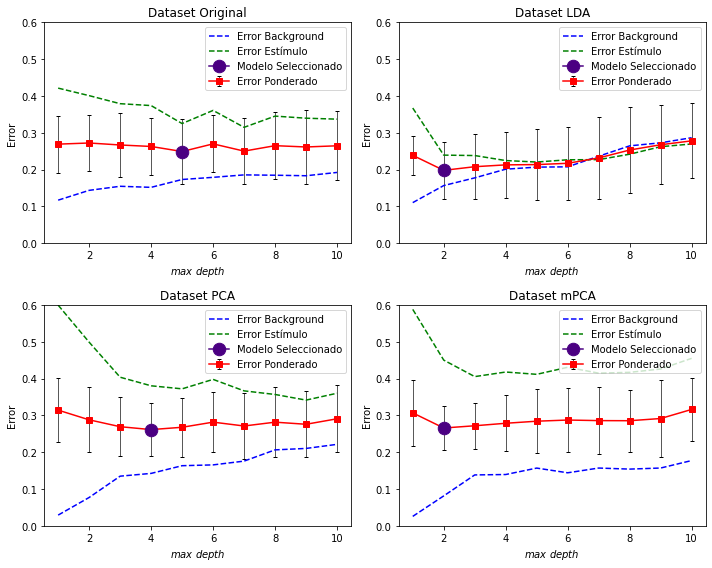

In [ ]:
# Plot error during train as a function of hyperparameters

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for result, best_model, ax, title in zip(list_results, best_models, axes.ravel(), dataset_names):
    ax.errorbar(result['max_depth'], result['Error Ponderado'], result['Error_std'], marker='s', 
                label='Error Ponderado', capsize=2, color='red', ecolor='black', elinewidth=0.65)
    ax.plot(result['max_depth'], result['Error Background'], ls='--', label='Error Background', color='blue')
    ax.plot(result['max_depth'], result['Error Estímulo'], ls='--', label='Error Estímulo', color='green')
    # Highlight Selected Model
    ax.plot(best_model.get_params()['max_depth'], 
            result[result['max_depth'] == best_model.get_params()['max_depth']]['Error Ponderado'],
            color='indigo', marker='o', markersize=12.5, zorder=3, label='Modelo Seleccionado')
    
    ax.set_xlabel('$max\ depth$')
    ax.set_ylabel('Error')
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_ylim([0, 0.6])

plt.tight_layout()
plt.show()
fig.savefig('Errores CV', dpi=320)

In [ ]:
def plot_cm(model, dataset_test, axis, title):
    labels=['Background', 'Vino', 'Plátano']
    win_preds_all = model.predict(dataset_test.iloc[:, :-3])
    confm = confusion_matrix(dataset_test['class'], win_preds_all)
    sn.heatmap(confm, annot=True, fmt='g', ax=axis)
    axis.text(-0.5, -0.25, 'Clase real')
    axis.text(2.5, 3.5, 'Clase predicha')
    axis.set_xticklabels(labels)
    axis.set_yticklabels(labels, va='center')
    axis.set_title(title)

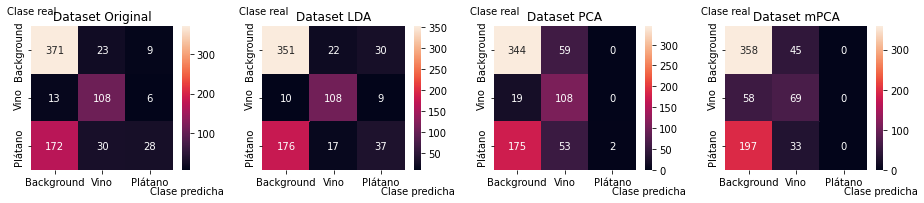

In [ ]:
# Matrices de confusión de los mejores modelos sobre test.
fig, axes = plt.subplots(1, 4, figsize=(13, 3))
for best_model, dataset_test, axis, title in zip(best_models, datasets_test, axes.ravel(), dataset_names):
    plot_cm(best_model, dataset_test, axis, title)

plt.tight_layout()
plt.show()
fig.savefig('CMs', dpi=320)

In [ ]:
# Errores (background, stimulus and weighted) de los mejores modelos sobre test
errores = []
for dataset_test, best_model in zip(datasets_test, best_models):
    errores.append(error_ponderado(dataset_test, best_model, ts_test, ts_meta_test))
    
# Show errors for each dataset
df_errors = pd.concat(errores, axis=0)
df_errors.insert(0, 'Dataset', dataset_names)
df_errors

,Dataset,Error Background,Error Estímulo,Error Ponderado
0,Dataset Original,0.183737,0.337310,0.260524
0,Dataset LDA,0.234431,0.352596,0.293513
0,Dataset PCA,0.235161,0.445167,0.340164
0,Dataset mPCA,0.167308,0.529387,0.348348


In [ ]:
def plot_decision_regions(X, y, clf, ax=None):
 
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx),
                         np.arange(y_min, y_max, hy))
 
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    Z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)
    
    cm = plt.get_cmap('viridis')
    
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cm)
    ax.contour(xx, yy, Z, colors='black', alpha=0.1)
    
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm, alpha=0.6)
    ax.legend([mpatches.Patch(color=cm(b)) for b in [0,0.5,1.0]],
           ['Background', "Vino", "Plátano"], loc='lower right')
    
 
    return ax

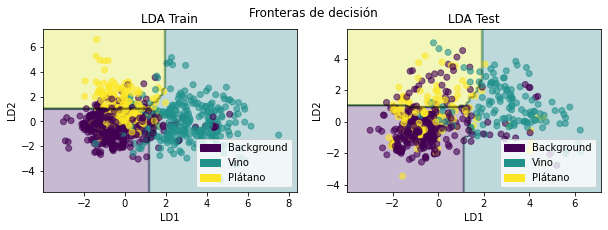

In [ ]:
# Plot LDA decision boundaries
data = [lda_win_data_train, lda_win_data_test]

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for idx, ax in enumerate(axes.ravel()):
    ax = plot_decision_regions(data[idx].iloc[:, :2].values, data[idx].iloc[:, -3].values, clf=best_models[1], ax=ax)
    ax.set_xlabel('LD1')
    ax.set_ylabel('LD2')

axes[0].set_title('LDA Train')
axes[1].set_title('LDA Test')
plt.suptitle('Fronteras de decisión')

plt.show()
fig.savefig('Decision Boundaries', dpi=320)

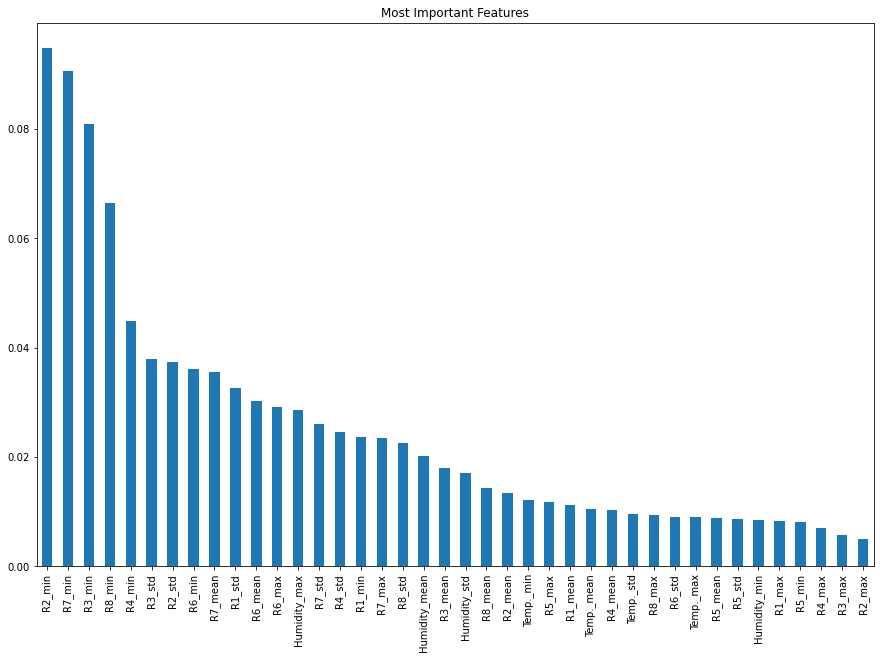

In [ ]:
# Most important features (Atributos más importantes para clasificar)

### La gráfica no cabe así que si acaso se comenta en la memoria.

feature_importances = pd.DataFrame(best_models[0].feature_importances_, index=win_data_train_sc.iloc[:, :-3].columns)

feature_importances.sort_values(by=0, ascending=False).plot.bar(figsize=(15, 10), legend=False)
plt.title('Most Important Features')
plt.show()